In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import *
import seaborn as sns
from qutip import *
import dimod
import pickle5 as pickle
import lzma
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from dwave.system import DWaveSampler
import gzip

kBT in eV = 1.3787527349893894e-06
A(s) near the A an B crossing in eV = 4.822118209274746e-06

Lowest A(s)/B(s) = -11.778741865509762, highest A(s)/B(s) = -0.0
Timescale 2\hbar/B(1) \mu s = 3.707312906869214e-05


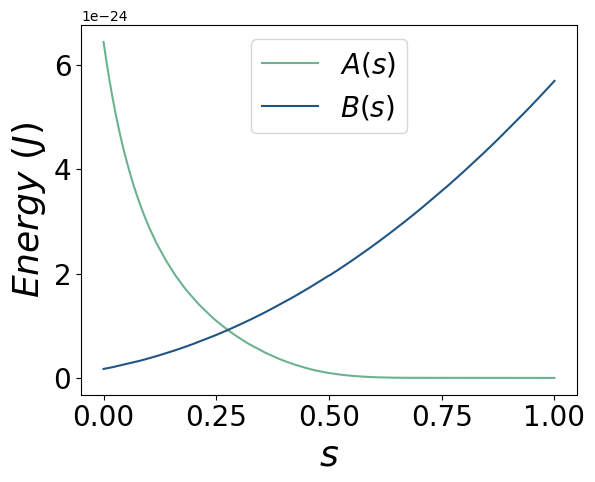

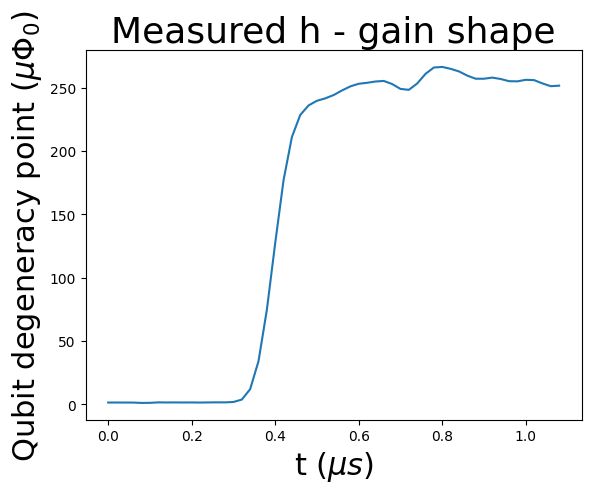

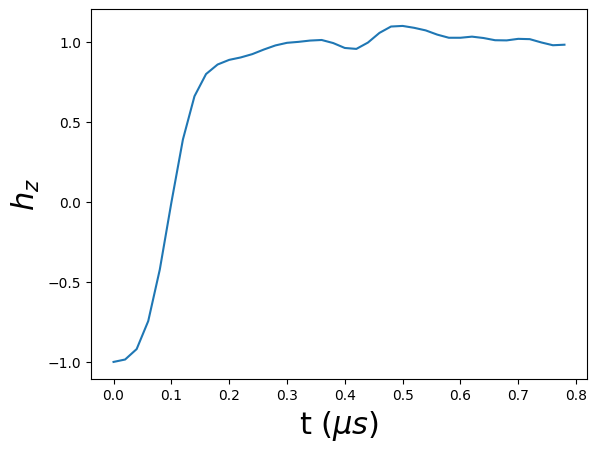

In [2]:
h=6.62607015*10**-34 # JHz^−1
hbar=h/2./np.pi
df = pd.read_csv('Data/09-1265A-D_Advantage_system5_4_annealing_schedule.csv', sep=',', decimal='.')
s = np.array([round(df['s'][i],3) for i in range(1000)])
A = [round(df['A(s) (GHz)'][i],3)*10**9*h for i in range(1000)]
B = [round(df['B(s) (GHz)'][i],3)*10**9*h for i in range(1000)]
fAm1 = interp1d(A, s)
fA = interp1d(s, A, fill_value="extrapolate")
fB = interp1d(s, B, fill_value="extrapolate")
kB=1.38064852*10**-23 # m^2kgs^-2K^-1
T=16.*10**-3 # pm 0.1 *10^-3 K
def s_to_hx(sv):
    ts = (s - sv)**2
    sv = s[list(ts).index(min(ts))]
    return -fA(sv)/fB(sv)
def s_array_to_hx(sv):
    ts = [(s - i)**2 for i in sv]
    sv = [s[list(i).index(min(i))] for i in ts]
    return -fA(sv)/fB(sv)
def hx_to_s(hxv, J=1):
    ma = [abs(s_to_hx(sv) - hxv) for sv in s]
    return s[ma.index(min(ma))]

print('kBT in eV = '+str(kB*T/(1.6022e-19)))
print('A(s) near the A an B crossing in eV = '+str(fA(.3)/(1.6022e-19))+'\n')

print('Lowest A(s)/B(s) = '+str(s_to_hx(.07))+', highest A(s)/B(s) = '+str(s_to_hx(1.4)))

print('Timescale 2\hbar/B(1) \mu s = '+str(2.*hbar/fB(1.)*10**6))

fig, ax = plt.subplots()
cmap = plt.get_cmap('crest')
colors = [cmap(i) for i in np.linspace(.2, .8, 2)]
plt.xlabel('$s$', fontsize = 26)
plt.ylabel('$Energy$ $(J)$', fontsize = 26)
ax.plot(s, A, color=colors[0])
ax.plot(s, B, color=colors[1])
ax.tick_params(axis='both', labelsize=20)
ax.legend(['$A(s)$', '$B(s)$'], fontsize=20)

h=6.62607015*10**-34 # JHz^−1
hbar=h/2./np.pi
df = pd.read_csv('Data/Advantage-degeneracy-point-versus-h-gain-starttime.csv', sep=',', decimal='.')
tar = np.array([round(df['Time us'][len(df)-1] - df['Time us'][i],3) for i in range(len(df))])
hz = np.array([round(df['Qubit degeneracy point (uPhi0)'][i],3) for i in range(len(df))])
hzerr = np.array([round(df['uncertainty'][i],3) for i in range(len(df))])

fig, ax = plt.subplots()
plt.title('Measured h - gain shape', fontsize = 26)
plt.xlabel('t ($\mu s$)', fontsize = 22)
plt.ylabel('Qubit degeneracy point ($\mu\Phi_0$)', fontsize = 22)
ax.plot(tar, hz)

hz = 2.*(hz - hz[3]/2)/hz[0]
tar = tar[15:]
hz = hz[:-15]

fig, ax = plt.subplots()
plt.xlabel('t ($\mu s$)', fontsize = 22)
plt.ylabel('$h_z$', fontsize = 22)
ax.plot(tar, hz)
fhgain = interp1d(tar, hz, fill_value="extrapolate")

def s_vs_t_full(t, irt, pt, mt, sv):
    """
    Interpolation function value at time t.

    Parameters:
    - t: Time at which to evaluate the interpolation function.
    - irt: Initial relative time.
    - pt: Duration of the plateau phase.
    - mt: Duration of the linear transition from sv to 1.
    - sv: Value of the function during the plateau phase.

    Returns:
    - Interpolated function value at time t.
    """

    # Define the time points and corresponding values
    """
    nop = 10.
    time_points = np.arange(0.,irt+pt+mt+(irt+pt+mt)/nop,(irt+pt+mt)/nop)
    values = []
    for time in time_points:
        if 0. <= time and time <= irt:
            values.append((sv-1.)/irt*time+1.)
        elif irt < time and time <= irt + pt:
            values.append(sv)
        elif pt < time and time <= (irt + pt + mt)*1.001:
            values.append((1.-sv)/mt*(time-irt-pt) + sv)
    """
    time_points = [0., irt, irt+pt,irt+pt+mt]
    values = [1.,sv,sv,1.]

    # Create interpolation function
    #interp_func = CubicSpline(time_points, values, extrapolate='bool', bc_type='natural')
    interp_func = PchipInterpolator(time_points, values, axis=0, extrapolate=None)
    
    # Evaluate the interpolation function at time t
    result = interp_func(t)

    return result

def hz_drive(t,t0,irt,pt,mt,qt,es,hzv):
    # All times should be dimensionless
    if 0. <= t and t < qt:
        return fhgain(0.) * hzv
    elif qt <= t and t <= qt + tar[0]/t0:
        return fhgain((t-qt)*t0) * hzv
    else:
        return fhgain(tar[0]) * hzv

def hx_drive(t,irt,pt,mt,sv):
    # All times should be dimensionless
    return -fA(s_vs_t_full(t,irt,pt,mt,sv))/fB(s_vs_t_full(t,irt,pt,mt,sv))

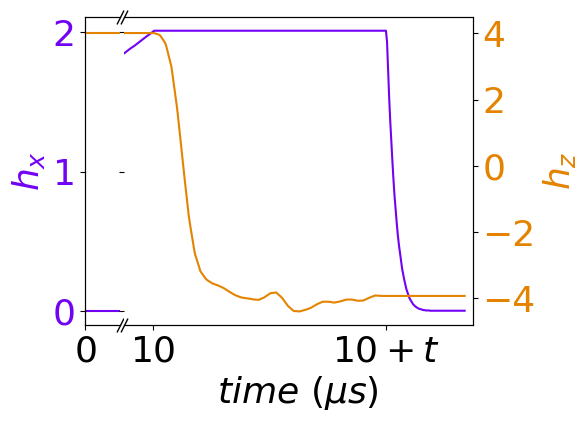

In [3]:
def s_vs_t_full(t,irt,pt,mt,sv):
    if 0. <= t and t <= irt:
        return (sv-1.)/irt*t+1.
    elif irt < t and t <= irt + pt:
        return sv
    elif pt < t and t <= irt + pt + mt:
        return (1.-sv)/mt*(t-irt-pt) + sv
    else:
        return 0.

def hx_drive(t,irt,pt,mt,sv):
    # All times should be dimensionless
    return -fA(s_vs_t_full(t,irt,pt,mt,sv))/fB(s_vs_t_full(t,irt,pt,mt,sv))

def plot_with_broken_x_axis(x, y, y1, xlim1, xlim2, ylim1=None, ylim2=None, ylim22=None, xlabel="$time$ $(\mu s)$", ylabel="$h_x$"):
    """
    Plot data with a broken x-axis to omit certain regions.
    
    Parameters:
    - x: array-like, the x-axis data
    - y: array-like, the y-axis data
    - xlim1: tuple, the limits for the first x-axis (e.g., (xmin1, xmax1))
    - xlim2: tuple, the limits for the second x-axis (e.g., (xmin2, xmax2))
    - ylim1: tuple or None, the y-axis limits for the first plot (default: auto)
    - ylim2: tuple or None, the y-axis limits for the second plot (default: auto)
    - xlabel: str, label for the x-axis
    - ylabel: str, label for the y-axis
    """
    
    cmap = plt.get_cmap('gnuplot')
    colors1 = [cmap(i) for i in np.linspace(.2, .8, 2)]

    # Create two subplots that share the y-axis and are broken on the x-axis
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(5, 4), gridspec_kw={'width_ratios': [1, 10]})
    fig.subplots_adjust(wspace=0.02)  # Adjust space between subplots
    ax12=ax1.twinx()
    ax22=ax2.twinx()
    plt.ticklabel_format(axis='both', style='sci', scilimits=(0,1))
    
    # Plot the data on both axes
    ax1.plot(x, y, color=colors1[0])
    ax2.plot(x, y, color=colors1[0])
    ax12.plot(x, y1, color=colors1[1])
    ax22.plot(x, y1, color=colors1[1])
    
    # Set x-axis limits for each subplot
    ax1.set_xlim(xlim1)
    ax2.set_xlim(xlim2)
    ax22.set_xlim(xlim2)
    ax1.set_xticks([0.], ['$0$'], fontsize=26)
    ax2.set_xticks([irt,irt+pt], ['$10$','$10+t$'], fontsize=26)
    ax22.set_xticks([irt,irt+pt], ['$10$','$10+t$'], fontsize=26)
    ax22.set_yticks([-4,-2,0,2,4])
    ax1.set_yticks([0.,.1,.2],[0,1,2])
    ax12.set_yticks([])
    
    # Set y-axis limits if provided
    if ylim1:
        ax1.set_ylim(ylim1)
    if ylim2:
        ax2.set_ylim(ylim2)
    if ylim22:
        ax12.set_ylim(ylim22)
        ax22.set_ylim(ylim22)
    
    # Set axis labels and title
    ax1.tick_params(axis='x',labelsize=26)
    ax1.tick_params(axis='y',labelsize=26, labelcolor = colors1[0])
    ax1.set_ylabel(ylabel, color=colors1[0], fontsize=26)
    ax2.set_xlabel(xlabel, fontsize = 26)
    ax22.tick_params(axis='y',labelsize=26, labelcolor = colors1[1])
    ax22.set_ylabel("$h_z$",color=colors1[1],fontsize=26)
    
    # Hide the spines between ax1 and ax2
    ax1.spines['right'].set_visible(False)
    ax12.spines['right'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax22.spines['left'].set_visible(False)
    
    # Add slanted lines to indicate the break in the x-axis
    d1, d2 = 1., 1.  # Proportion of slanted line
    kwargs1 = dict(marker=[(-.5, -d1), (.5, d1)], markersize=10, linestyle="none", color='k', mec='k', mew=1, clip_on=False)
    kwargs11 = dict(marker=[(-.5, -d1), (.5, d1)], markersize=10, linestyle="none", color='k', mec='k', mew=1, clip_on=False)
    kwargs2 = dict(marker=[(-.5, -d2), (.5, d2)], markersize=10, linestyle="none", color='k', mec='k', mew=1, clip_on=False)
    
    # Slanted lines between ax1 and ax2 (to indicate the break)
    ax1.plot([1], [0], transform=ax1.transAxes, **kwargs1)
    ax1.plot([1], [1], transform=ax1.transAxes, **kwargs11)
    #ax2.plot([0, 0], [0, 1], transform=ax2.transAxes, **kwargs2)
    ax22.plot([0, 0], [0, 1], transform=ax22.transAxes, **kwargs2)

    plt.savefig('Images/Fig1b.pdf', bbox_inches='tight')
    plt.savefig('Images/Fig1b.svg', bbox_inches='tight')
    plt.savefig('Images/Fig1b.png', bbox_inches='tight')
    plt.show()

es = fB(1.)*1.
t0 = 100 * hbar/es*2.*10**6 # energy timescale of H(t) in \mu s
#pts = np.linspace(.0001,2.,100) # pause time in \mu s
pts = np.array([.8]) # pause time in \mu s
irts = [10.] # initial ramp time in \mu s
mts = [.272] # measurement time in \mu s
tauzs = [.4]
hxrange = -np.array([.2])
hz_value = np.array([4.])

for irt in irts:
    for mt in mts:
        for tauz in tauzs:
            
            qt = irt
            [irtd,ptds,mtd,qtd] = [irt/t0,pts/t0,mt/t0,qt/t0] # Dimensionless version of annealing schedule parameters for numerical simulation
            
            for ptind, pt in enumerate(pts):
                
                times=np.linspace(0.0,irt+pts[ptind]+mt,int((irt+pts[ptind]+mt)//t0)) # Times for plotting in \mu s
                tlist=np.linspace(0.0,(irt+pts[ptind]+mt-t0)/t0,int((irt+pts[ptind]+mt)//t0)) # Dimensionless times for numerical simulation

                for sind in range(len(hxrange)):

                    sv = hx_to_s(hxrange[sind])
                    hx = hxrange[sind] # x magnetic field strength

                    SHX = CubicSpline(tlist, [hx_drive(t,irtd,ptds[ptind],mtd,sv) for t in tlist], extrapolate='bool', bc_type='natural')

                    x = times
                    y = [-SHX(t) for t in tlist]

                    for hzind, hzv in enumerate(hz_value):

                        hzv = hz_value[hzind] # z magnetic field strength
                        SHZ = Cubic_Spline(tlist[0], tlist[-1], [hz_drive(t,t0,irtd,ptds[ptind],mtd,qtd,es,hzv) for t in tlist])
                        #ax2.set_yticks([])
                        y1 = [-SHZ(t) for t in tlist]
                        plot_with_broken_x_axis(x, y, y1, xlim1=(0., 1.), xlim2=(9.9, 11.1), ylim22=[-4.8,4.5])

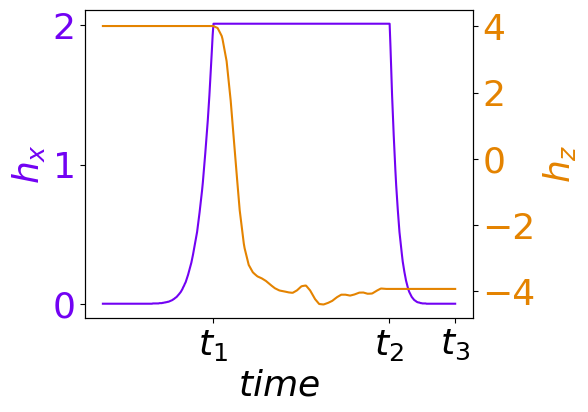

In [13]:
def s_vs_t_full(t,irt,pt,mt,sv):
    if 0. <= t and t <= irt:
        return (sv-1.)/irt*t+1.
    elif irt < t and t <= irt + pt:
        return sv
    elif pt < t and t <= irt + pt + mt:
        return (1.-sv)/mt*(t-irt-pt) + sv
    else:
        return 0.

def hx_drive(t,irt,pt,mt,sv):
    # All times should be dimensionless
    return -fA(s_vs_t_full(t,irt,pt,mt,sv))/fB(s_vs_t_full(t,irt,pt,mt,sv))

def plot_with_twin_axis(x, y, y1, ylim1=None, ylim2=None, ylim22=None, xlabel="$time$", ylabel="$h_x$"):
    """
    Plot data with a broken x-axis to omit certain regions.
    
    Parameters:
    - x: array-like, the x-axis data
    - y: array-like, the y-axis data
    - xlim1: tuple, the limits for the first x-axis (e.g., (xmin1, xmax1))
    - xlim2: tuple, the limits for the second x-axis (e.g., (xmin2, xmax2))
    - ylim1: tuple or None, the y-axis limits for the first plot (default: auto)
    - ylim2: tuple or None, the y-axis limits for the second plot (default: auto)
    - xlabel: str, label for the x-axis
    - ylabel: str, label for the y-axis
    """
    
    cmap = plt.get_cmap('gnuplot')
    colors1 = [cmap(i) for i in np.linspace(.2, .8, 2)]

    # Create two subplots that share the y-axis and are broken on the x-axis
    fig, ax1 = plt.subplots(figsize=(5, 4))
    ax12=ax1.twinx()
    plt.ticklabel_format(axis='both', style='sci', scilimits=(0,1))
    
    # Plot the data on both axes
    ax1.plot(x, y, color=colors1[0])
    ax12.plot(x, y1, color=colors1[1])
    
    # Set x-axis limits for each subplot
    ax1.set_xticks([0.], ['$0$'], fontsize=26)
    ax12.set_xticks([irt,irt+pt,irt+pt+mt], ['$t_{1}$','$t_{2}$','$t_{3}$'], fontsize=26)
    ax12.set_yticks([-4,-2,0,2,4])
    ax1.set_yticks([0.,.1,.2],[0,1,2])
    
    # Set y-axis limits if provided
    if ylim1:
        ax1.set_ylim(ylim1)
    if ylim22:
        ax12.set_ylim(ylim22)
    
    # Set axis labels and title
    ax1.tick_params(axis='x',labelsize=26)
    ax1.tick_params(axis='y',labelsize=26, labelcolor = colors1[0])
    ax1.set_ylabel(ylabel, color=colors1[0], fontsize=26)
    ax1.set_xlabel(xlabel, fontsize = 26)
    ax12.tick_params(axis='y',labelsize=26, labelcolor = colors1[1])
    ax12.set_ylabel("$h_z$",color=colors1[1],fontsize=26)

    plt.savefig('Images/Fig1b.pdf', bbox_inches='tight')
    plt.savefig('Images/Fig1b.svg', bbox_inches='tight')
    plt.savefig('Images/Fig1b.png', bbox_inches='tight')
    plt.show()

es = fB(1.)*1.
t0 = 100 * hbar/es*2.*10**6 # energy timescale of H(t) in \mu s
#pts = np.linspace(.0001,2.,100) # pause time in \mu s
pts = np.array([.8]) # pause time in \mu s
irts = [.5] # initial ramp time in \mu s
mts = [.3] # measurement time in \mu s
hxrange = -np.array([.2])
hz_value = np.array([4.])

for irt in irts:
    for mt in mts:
        for tauz in tauzs:
            
            qt = irt
            [irtd,ptds,mtd,qtd] = [irt/t0,pts/t0,mt/t0,qt/t0] # Dimensionless version of annealing schedule parameters for numerical simulation
            
            for ptind, pt in enumerate(pts):
                
                times=np.linspace(0.0,irt+pts[ptind]+mt,int((irt+pts[ptind]+mt)//t0)) # Times for plotting in \mu s
                tlist=np.linspace(0.0,(irt+pts[ptind]+mt-t0)/t0,int((irt+pts[ptind]+mt)//t0)) # Dimensionless times for numerical simulation

                for sind in range(len(hxrange)):

                    sv = hx_to_s(hxrange[sind])
                    hx = hxrange[sind] # x magnetic field strength

                    SHX = CubicSpline(tlist, [hx_drive(t,irtd,ptds[ptind],mtd,sv) for t in tlist], extrapolate='bool', bc_type='natural')

                    x = times
                    y = [-SHX(t) for t in tlist]

                    for hzind, hzv in enumerate(hz_value):

                        hzv = hz_value[hzind] # z magnetic field strength
                        SHZ = Cubic_Spline(tlist[0], tlist[-1], [hz_drive(t,t0,irtd,ptds[ptind],mtd,qtd,es,hzv) for t in tlist])
                        #ax2.set_yticks([])
                        y1 = [-SHZ(t) for t in tlist]
                        plot_with_twin_axis(x, y, y1, ylim22=[-4.8,4.5])

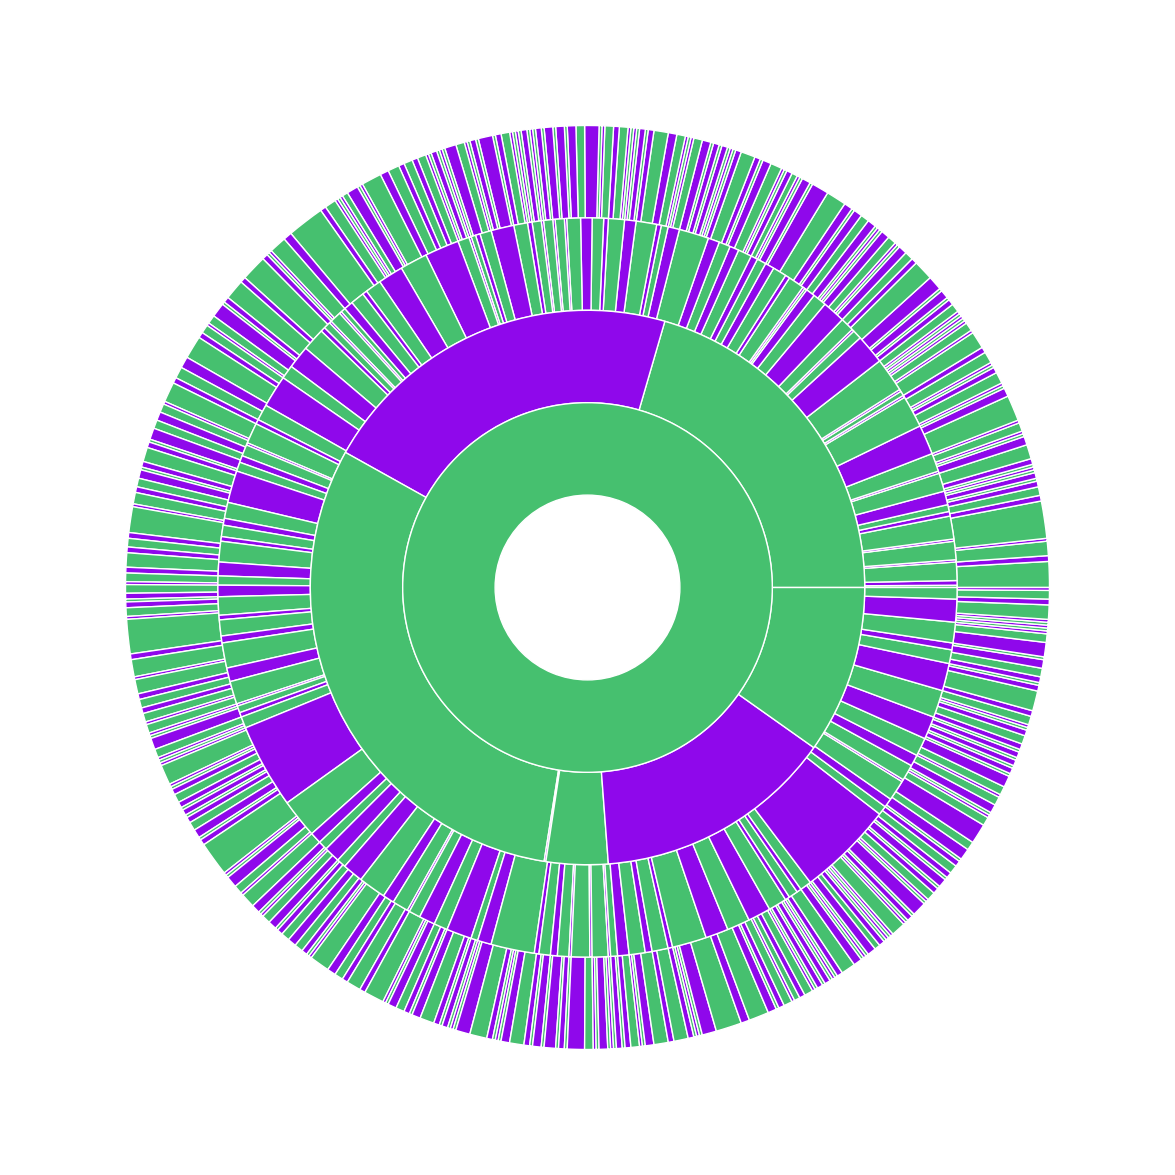

In [4]:
analysis_results_dir = 'Data/'
f = 'FVD_TFIM_L_5564_J_-1_0_hx_0_002_hz_-0_9_is_all_1_as_ra_s_0_639_irt_100_0_pt_2_0_mt_0_1805_hss_q_qt_0_0_nr_1000_emb_re54_LQ_5564_PQ_5564_am_raw_as_False_rt_0_0_rs_True_info.txt'

results = dimod.SampleSet.from_serializable(pickle.load(lzma.open(analysis_results_dir + f,'rb'))).to_pandas_dataframe().to_numpy()
data = results[:,:-3]  # we don't need energy and chain break fraction
num_occurrences = results[:,-1]
Nspins = data.shape[1]
data1 = data[0]

f = 'FVD_TFIM_L_5564_J_-1_0_hx_0_002_hz_-2_0_is_all_1_as_ra_s_0_639_irt_100_0_pt_2_0_mt_0_1805_hss_q_qt_0_0_nr_1000_emb_re54_LQ_5564_PQ_5564_am_raw_as_False_rt_0_0_rs_True_info.txt'

results = dimod.SampleSet.from_serializable(pickle.load(lzma.open(analysis_results_dir + f,'rb'))).to_pandas_dataframe().to_numpy()
data = results[:,:-3]  # we don't need energy and chain break fraction
num_occurrences = results[:,-1]
Nspins = data.shape[1]
data2 = -data[0]

f = 'FVD_TFIM_L_5564_J_-1_0_hx_0_05_hz_-0_5_is_all_1_as_ra_s_0_497_irt_10_0_pt_1_0_mt_0_2515_hss_q_qt_0_0_nr_1000_emb_re54_LQ_5564_PQ_5564_am_raw_as_False_rt_0_0_rs_True_info.txt'

results = dimod.SampleSet.from_serializable(pickle.load(lzma.open(analysis_results_dir + f,'rb'))).to_pandas_dataframe().to_numpy()
data = results[:,:-3]  # we don't need energy and chain break fraction
num_occurrences = results[:,-1]
Nspins = data.shape[1]
data3 = -data[0]

f = 'FVD_TFIM_L_5564_J_-1_0_hx_0_1_hz_-0_1_is_all_1_as_ra_s_0_456_irt_10_0_pt_1_0_mt_0_272_hss_q_qt_0_0_nr_1000_emb_re54_LQ_5564_PQ_5564_am_raw_as_False_rt_0_0_rs_True_info.txt'

results = dimod.SampleSet.from_serializable(pickle.load(lzma.open(analysis_results_dir + f,'rb'))).to_pandas_dataframe().to_numpy()
data = results[:,:-3]  # we don't need energy and chain break fraction
num_occurrences = results[:,-1]
Nspins = data.shape[1]
data4 = -data[0]

def consecutive(data, stepsize=0):
    return np.split(data, np.where(np.diff(data) != stepsize)[0]+1)

fig, ax = plt.subplots(figsize=(15,15))

size = 0.4

cmap1 = plt.get_cmap('gnuplot')
cmap2 = plt.get_cmap('viridis')
outer_colors = [cmap2(180),cmap1(80)]

ax.pie(np.array([len(l) for l in consecutive((1+data2[:1000])/2)]), radius=1-size*0/2, colors=outer_colors,
    wedgeprops=dict(width=size/2, edgecolor='w'))

ax.pie(np.array([len(l) for l in consecutive((1+data3[:1000])/2)]), radius=1-size*1/2, colors=outer_colors,
    wedgeprops=dict(width=size/2, edgecolor='w'))

ax.pie(np.array([len(l) for l in consecutive((1+data4[:1000])/2)]), radius=1-size*2/2, colors=outer_colors,
    wedgeprops=dict(width=size/2, edgecolor='w'))
    
ax.pie(np.array([len(l) for l in consecutive((1+data1[:1000])/2)]), radius=1-size*3/2, colors=outer_colors,
    wedgeprops=dict(width=size/2, edgecolor='w'))

plt.savefig('Images/Fig1d.pdf', bbox_inches='tight')
plt.savefig('Images/Fig1d.svg', bbox_inches='tight')
plt.savefig('Images/Fig1d.png', bbox_inches='tight')
plt.show()

Connected to sampler Advantage_system5.4
Maximum slope allowed on this solver is 2.00.
*WARNING* PLEASE CHECK! h gain schedule max slope:  399.0


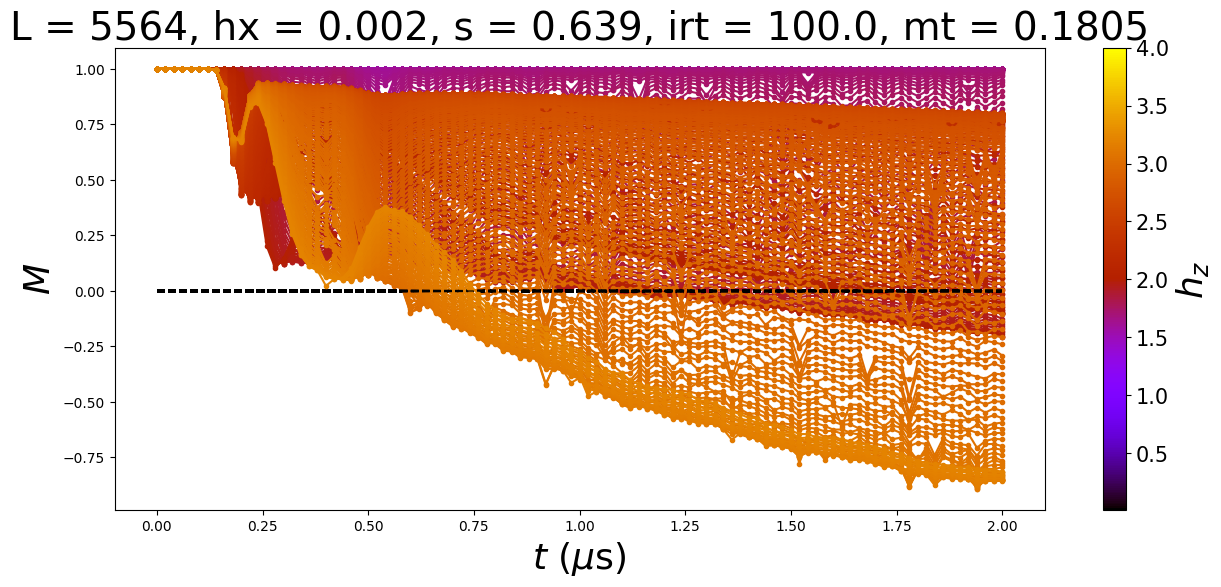

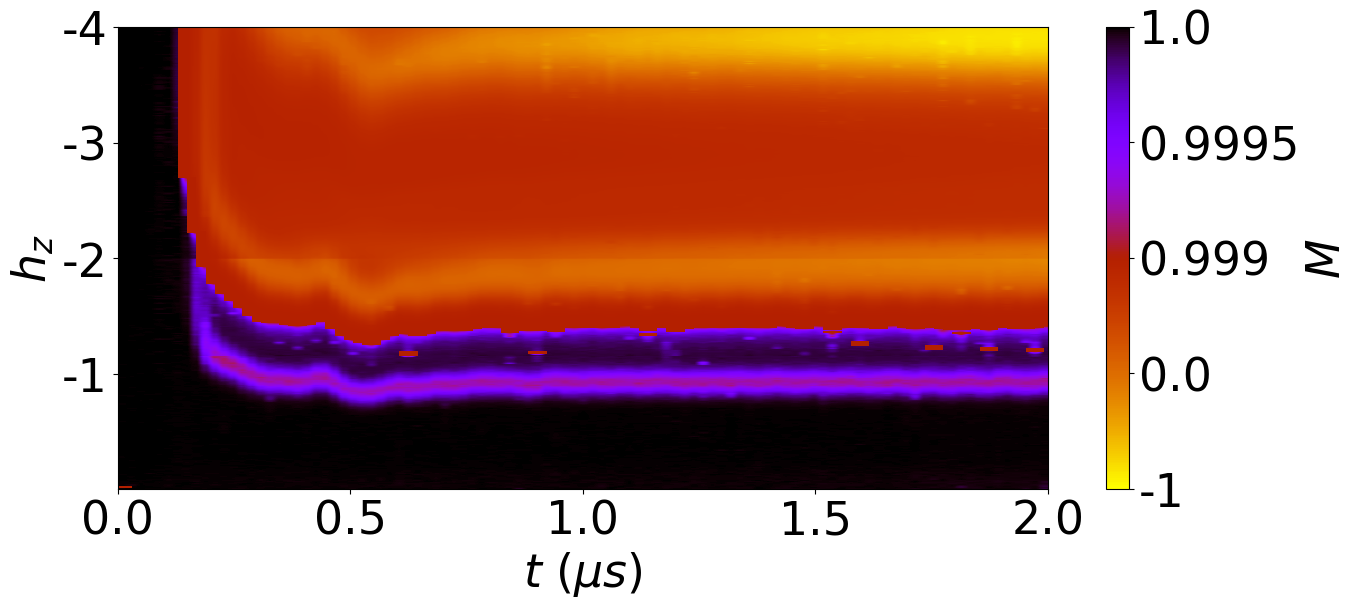

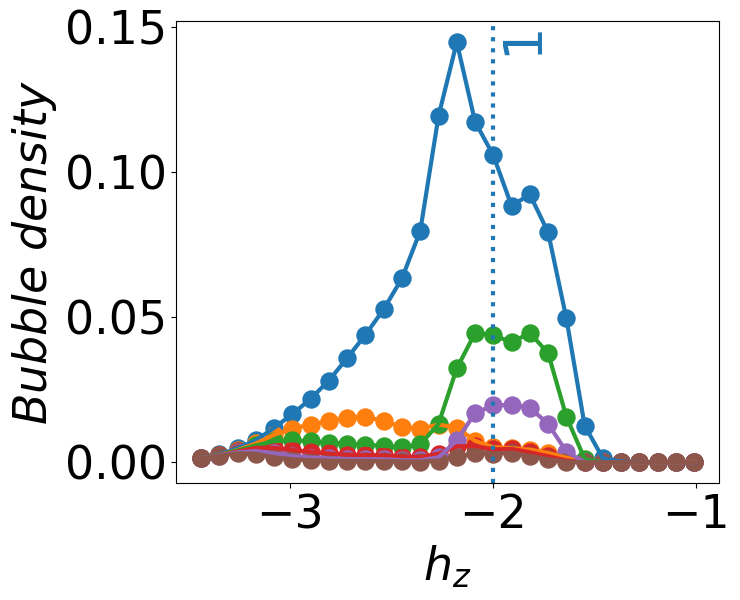

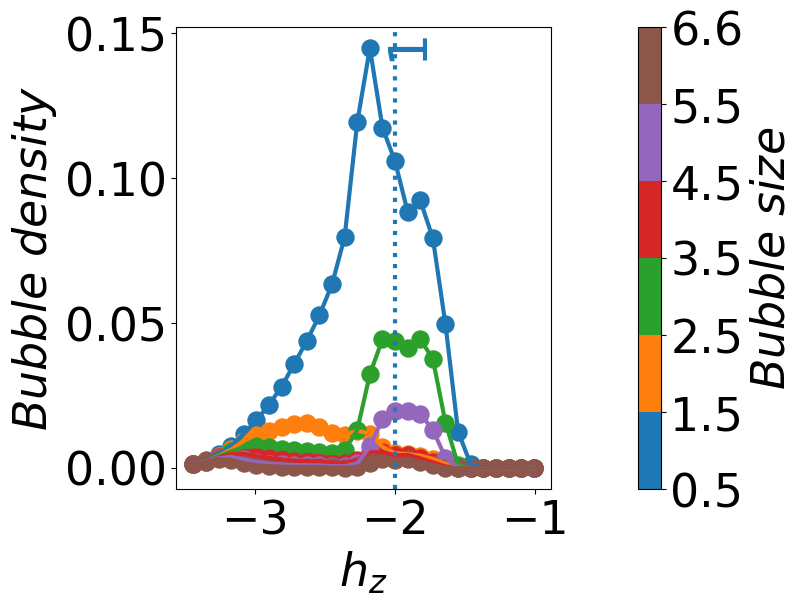

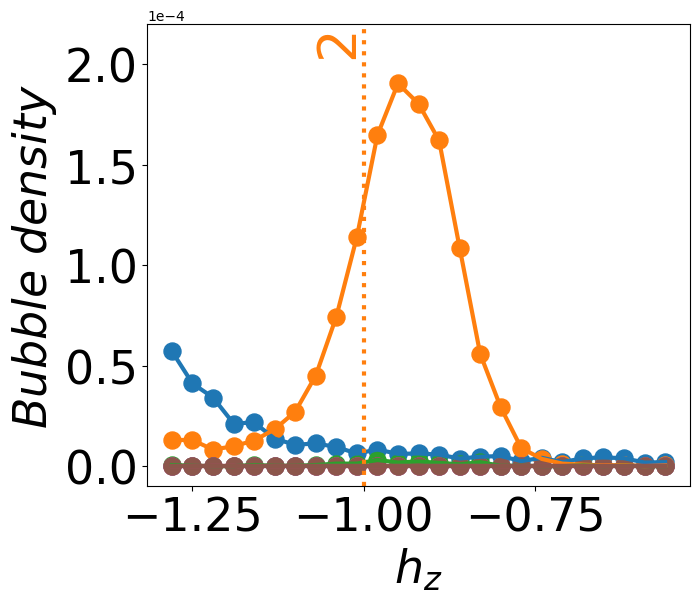

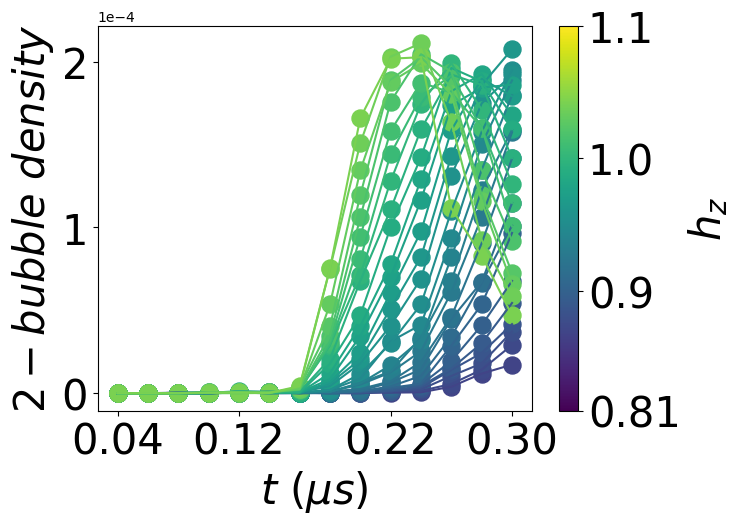

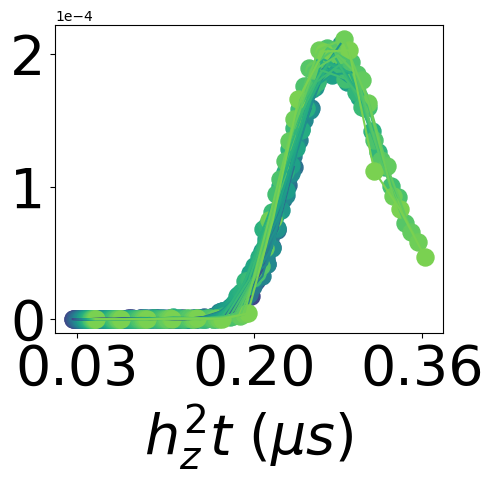

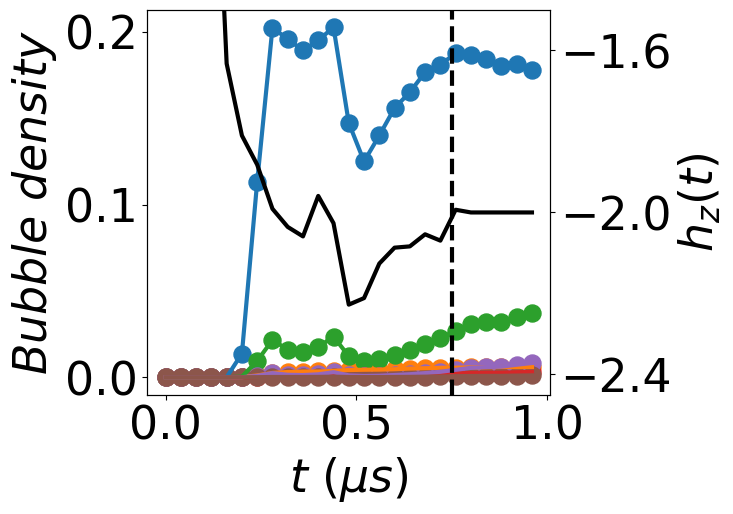

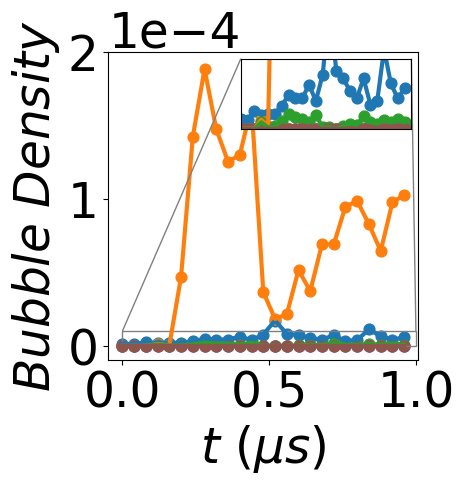

In [5]:
"""
FALSE VACUUM DECAY PARAMETERS
"""

# Specify the number of spins
number_of_spins = [5564]
# Specify the value of J in the transverse field Ising model
J_value = [-1.0]
# Specify the value of hx in the transverse field Ising model
hx_value = np.array([.002])

"""
QUANTUM ANNEALING PARAMETERS
"""

# Specify the D-Wave Leap user profile to use when submitting jobs
profil = 'jvodebjuelich'
sampler = DWaveSampler(profile=profil)
print("Connected to sampler", sampler.solver.name)
# Specify the maximum slope in annealing schedule
max_slope = 1./sampler.properties["annealing_time_range"][0]
print("Maximum slope allowed on this solver is {:.2f}.".format(max_slope))
# Specify the maximum slope in hz schedule
h_max_slope = 399.
print(f"*WARNING* PLEASE CHECK! h gain schedule max slope: ", h_max_slope)
# Specify the number of reads from the annealer
number_of_reads = [1000]
# Specify dir for storing results
results_dir = 'C:\\Users\\jakav\\Desktop\\False vacuum decay temporary\\Rezultati\\'
# Specify the mode of output from the D-Wave machine, either time - 'raw' or energy - 'histogram' ordered
answer_mode = 'raw'
# Specify whether to use D-Wave's auto scaling for the couplings and external fields or not
auto_scale = False
# Specify the value for the weight of physical qubits chains comprising logical qubits
chain_strength = 1.
# Specify how to obtain the embedding, either calculate a new one (embedding_string='new') or use an existing one from file (embedding_string='existing')
embedding_string = 'ring-embedding-5.4-'
# Specify how to obtain the embedding, either calculate a new one (embedding_string='new') or use an existing one from file (embedding_string='existing')
embedding_string_short = 're54'
# Specify the dir of the embeddings to be used
embedding_dir = 'C:\\Users\\jakav\\Desktop\\False vacuum decay temporary\\Embeddings\\'
# Specify for embeddings made apriori the number of physical qubits NP required for NL logical qubits {NL: NP}
embnpqs = {10: 10, 50: 50, 100: 100, 500: 500, 1000: 1001, 2000: 2000, 3000: 3004, 4000: 4001, 5000: 5000, 5447: 5447, 5564: 5564, 5565: 5565}
# Specify how long to wait in us in between individual runs in the same submission
readout_thermalization = 0.
# Specify what values A(sr) and B(sr) are to be reached in the pause section of the annealing schedule
#s_value = [hx_to_s(hxv, abs(J)) for hxv in hx_value]
# Specify the type of annealing schedule, either 'pause_anneal' or 'reverse_anneal'
anneal_schedule_string = 'ra'

"""PAUSE ANNEALING PARAMETERS"""

# Specify when in us the second rampup ends and therefore the whole pause anneal schedule
anneal_time = ['NOT USED HERE']
# Specify when in us to end the first rampup, starting the pause
begin_pause = ['NOT USED HERE']
# Specify when in us to begin the second rampup, ending the pause
end_pause = ['NOT USED HERE']

"""REVERSE ANNEALING PARAMETERS"""

# Specify the duration in us of the duration of the first linear ramp down from s=1 to s=s_value
initial_ramp_time = [100.]
# Specify the duration in us of the pause duration at s=s_value
t1 = np.linspace(0.,2.,num=101).round(3)
#pause_time = np.concatenate((t1, t2, t3, t4))
pause_time = t1
# Specify the duration in us of the measurement linear ramp from s=s_value back to s=1
measurement_time = [0.]
# Specify the description of the classical initial state of the system, e.g. [0, 1, 1, 0, 0, ...]
init_state = 'all_1'
# Specify wheter to reinitialize always back to init_state before performing another reverse anneal
reinitialize_state = True

"""hz SCHEDULE QUENCH PARAMETERS"""

# Specify the type of h schedule
h_schedule_string = 'q'
# Specify the magnitude of the hz field
hz_value = -np.linspace(0.01,4.,num=400).round(3)
#Specify the time of the quench
quench_time = [0.]
#offset_time = [round(t, 2) for t in np.arange(-0.3, 0., 0.01)]

analysis_results_dir = 'Data/'

with gzip.open(analysis_results_dir + 'fvd_mags_11th_sweep_LZ_check.txt.gz', "r") as f:
    fvd_mags = eval(f.read())
    
df = pd.read_csv('Data/09-1265A-D_Advantage_system5_4_annealing_schedule.csv')

h=6.62607015*10**-34 # JHz^−1
ss = [round(df['s'][i],3) for i in range(1000)]
AA = [round(df['A(s) (GHz)'][i],3)*10**9*h for i in range(1000)]
BB = [round(df['B(s) (GHz)'][i],3)*10**9*h for i in range(1000)]
ab_ratio = [a / b for a,b in zip(AA, BB)]

# Definition of conversion from hx field to s value
def hx_to_s(hxv, J=1):
    ma = [abs(s_to_hx(s, abs(J)) - hxv) for s in ss]
    return ss[ma.index(min(ma))]

# Definition of conversion from s value to hx field
def s_to_hx(s, J=1):
    index_s = ss.index(s)
    ab = ab_ratio[index_s]
    return ab/abs(J)

x_axis = pause_time

for jv in J_value:
    for irt in initial_ramp_time:
        for mt in measurement_time:
            for qt in quench_time:
                for nr in number_of_reads:
                    
                    for nos in number_of_spins:
                        for hxv in hx_value:
                            
                            dta = (1.-hx_to_s(hxv))/max_slope
                            if mt == 0.:
                                mt = round(dta,6)
                            
                            third_axis = np.array(hz_value)
                            third_axis_name = '$h_z$'
                            
                            cmap = plt.get_cmap('gnuplot')
                            colors = [cmap(i) for i in np.linspace(.2, .8, len(third_axis))]
                            fig, axs = plt.subplots(figsize=(15, 6))
                            plt.title('L = '+str(nos)+', hx = '+str(hxv)+', s = '+str(hx_to_s(hxv))+', irt = '+str(irt)+', mt = '+str(mt), fontsize = 28)
                            normalize = mcolors.Normalize(vmin=min(abs(third_axis)), vmax=max(abs(third_axis)))
                            colormap = plt.get_cmap('gnuplot')
                            scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
                            scalarmappaple.set_array(third_axis)
                            cbar = plt.colorbar(scalarmappaple)
                            cbar.set_label(label=third_axis_name, size='26')
                            cbar.ax.tick_params(labelsize='15')
                            plt.xlabel('$t$ ($\mu$s)', fontsize = 26)
                            plt.ylabel('$M$', fontsize = 26)
                            
                            cnt = 0
                            
                            for ta in third_axis:
                                    
                                x = []
                                y = []
                                
                                for xa in x_axis:
                                    
                                    try:
                                        y.append(fvd_mags[(nos,jv,hxv,ta,irt,xa,mt,qt,nr,'mean')]/nos)
                                        x.append(xa)
                                    except:
                                        continue
                                    
                                axs.hlines(0., min(x_axis), max(x_axis), linestyles='dashed', colors='black', alpha=0.6)
                                    
                                axs.plot(x, y, '.-', color=colors[cnt], label=f'hzv={third_axis[cnt]}')
                                
                                cnt += 1

third_axis = np.linspace(-1.,1.,100)
third_axis_name = r'$M$'

fig, ax = plt.subplots(figsize=(15,6))
plt.xlabel('$t$ ($\mu s$)', fontsize = 33)
plt.ylabel('$h_z$', fontsize = 33)
ax.tick_params(axis='both', which='major', labelsize=33)

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = mcolors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmap = plt.get_cmap('gnuplot')
cmap1 = truncate_colormap(cmap, 1., .5)
cmap2 = truncate_colormap(cmap, .5, .0)
cmap3 = truncate_colormap(cmap, 1., .0)

colors1 = cmap1(np.linspace(0., 1, 128))
colors2 = cmap2(np.linspace(0, 1, 128))

x = pause_time
y = -np.array(hz_value)
z1 = np.empty((len(y),len(x)))
z2 = np.empty((len(y),len(x)))
z3 = np.empty((len(y),len(x)))
for ita, ta in enumerate(-y):
    for ixa, xa in enumerate(x):
        z3[len(y)-1-ita,ixa] = .9999
        try:
            mag_temp = fvd_mags[(nos,jv,hxv,ta,irt,xa,mt,qt,nr,'mean')]/nos
            if mag_temp <= .999:
                z1[len(y)-1-ita,ixa] = mag_temp
                z2[len(y)-1-ita,ixa] = np.nan
            else:
                z1[len(y)-1-ita,ixa] = np.nan
                z2[len(y)-1-ita,ixa] = mag_temp
        except:
            z1[len(y)-1-ita,ixa] = np.nan
            z2[len(y)-1-ita,ixa] = np.nan
ax.imshow(z3, vmin=-1, vmax=1., extent=(np.amin(x), np.amax(x), np.amin(y), np.amax(y)), cmap=cmap1, aspect='auto')
im = ax.imshow(z1, vmin=-1., vmax=1, extent=(np.amin(x), np.amax(x), np.amin(y), np.amax(y)), cmap=cmap1, aspect='auto')
ax.imshow(z2, vmin=.999, vmax=1., extent=(np.amin(x), np.amax(x), np.amin(y), np.amax(y)), cmap=cmap2, aspect='auto')

ax.grid(False)
ax.set_yticks([1,2,3,4])
ax.set_yticklabels([-1,-2,-3,-4])

normalize = mcolors.Normalize(vmin=min(third_axis), vmax=max(third_axis))
colormap = cmap3
scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=cmap3)
scalarmappaple.set_array(third_axis)
cbar = plt.colorbar(scalarmappaple)
cbar.set_label(label=third_axis_name, size='33')
cbar.ax.tick_params(labelsize='33')
cbar.set_ticks([-1,-.5,0,.5,1])
cbar.set_ticklabels([-1,0.,.999,.9995,1.])
plt.savefig('Images/Fig1e.pdf', bbox_inches='tight')
plt.savefig('Images/Fig1e.svg', bbox_inches='tight')
plt.savefig('Images/Fig1e.png', bbox_inches='tight')

x_axis = np.array(hz_value[100:350:9])

for jv in J_value:
    for irt in initial_ramp_time:
        for mt in measurement_time:
            for qt in quench_time:
                for nr in number_of_reads:
                    
                    for nos in number_of_spins:
                        for hxv in hx_value:
                            
                            dta = (1.-hx_to_s(hxv))/max_slope
                            if mt == 0.:
                                mt = round(dta,6)
                            
                            pt = pause_time[-1]
                            
                            third_axis = ['l1','l2','l3','l4','l5','l6']
                            third_axis_name = '$Bubble$ $size$'
                            
                            colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
                            fig, axs = plt.subplots(figsize=(7, 6))
                            #axs.set_title('$pt$ ='+str(pt)+' $\mu$s', fontsize = 28)
                            plt.xlabel('$h_z$', fontsize = 33)
                            plt.ylabel('$Bubble$ $density$', fontsize = 33)
                            markers = [str(i) for i in range(1,21)]
                            axs.tick_params(axis='both', labelsize=33)
                            
                            cnt = 0
                            
                            for ta in third_axis:
                                    
                                x = []
                                y = []
                                
                                for xa in x_axis:

                                    try:
                                        y.append(fvd_mags[(nos,jv,hxv,xa,irt,pt,mt,qt,nr,ta)])
                                        x.append(xa)
                                    except:
                                        continue
                                    
                                axs.plot(x, y, ls='solid', lw=3, color=colors[cnt])
                                axs.scatter(x, y, s=150, color=colors[cnt])
                                #for xi,yi in zip(x,y):
                                #    axs.text(xi, yi, markers[cnt], color=colors[cnt], fontsize=22)
                                
                                cnt += 1

for res in [1]:
    axs.axvline(-2/res, color=colors[res-1], ls=':', lw=3)
    axs.text(-2/res + .27, 1., str(res), fontsize=38, color=colors[res-1], ha='right', va='top', rotation=90,
         transform=axs.get_xaxis_transform())
plt.savefig('Images/Fig2a.pdf', bbox_inches='tight')
plt.savefig('Images/Fig2a.svg', bbox_inches='tight')
plt.savefig('Images/Fig2a.png', bbox_inches='tight')

x_axis = np.array(hz_value[100:350:9])

for jv in J_value:
    for irt in initial_ramp_time:
        for mt in measurement_time:
            for qt in quench_time:
                for nr in number_of_reads:
                    
                    for nos in number_of_spins:
                        for hxv in hx_value:
                            
                            dta = (1.-hx_to_s(hxv))/max_slope
                            if mt == 0.:
                                mt = round(dta,6)
                            
                            pt = pause_time[-1]
                            
                            third_axis = ['l1','l2','l3','l4','l5','l6']
                            third_axis_name = '$Bubble$ $size$'
                            
                            colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
                            fig, axs = plt.subplots(figsize=(7, 6))
                            cmap = (mcolors.ListedColormap(colors))
                            bounds = [.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.6]
                            norm = mcolors.BoundaryNorm(bounds, cmap.N)
                            scalarmappaple = cm.ScalarMappable(cmap=cmap, norm=norm)
                            scalarmappaple.set_array(bounds)
                            cbar = plt.colorbar(scalarmappaple, pad=.16)
                            cbar.set_label(label=third_axis_name, size='33')
                            cbar.ax.tick_params(labelsize='33')
                            plt.xlabel('$h_z$', fontsize = 33)
                            plt.ylabel('$Bubble$ $density$', fontsize = 33)
                            markers = [str(i) for i in range(1,21)]
                            axs.tick_params(axis='both', labelsize=33)
                            
                            cnt = 0
                            
                            for ta in third_axis:
                                    
                                x = []
                                y = []
                                
                                for xa in x_axis:

                                    try:
                                        y.append(fvd_mags[(nos,jv,hxv,xa,irt,pt,mt,qt,nr,ta)])
                                        x.append(xa)
                                    except:
                                        continue
                                    
                                axs.plot(x, y, ls='solid', lw=3, color=colors[cnt])
                                axs.scatter(x, y, s=150, color=colors[cnt])
                                #for xi,yi in zip(x,y):
                                #    axs.text(xi, yi, markers[cnt], color=colors[cnt], fontsize=22)
                                
                                cnt += 1

for res in [1]:
    axs.axvline(-2/res, color=colors[res-1], ls=':', lw=3)
    axs.text(-2/res + .27, 1., str(res), fontsize=38, color=colors[res-1], ha='right', va='top', rotation=90,
         transform=axs.get_xaxis_transform())
plt.savefig('Images/Fig2aColorBar.pdf', bbox_inches='tight')
plt.savefig('Images/Fig2aColorBar.svg', bbox_inches='tight')
plt.savefig('Images/Fig2aColorBar.png', bbox_inches='tight')

x_axis = np.array(hz_value[55:130:3])

for jv in J_value:
    for irt in initial_ramp_time:
        for mt in measurement_time:
            for qt in quench_time:
                for nr in number_of_reads:
                    
                    for nos in number_of_spins:
                        for hxv in hx_value:
                            
                            dta = (1.-hx_to_s(hxv))/max_slope
                            if mt == 0.:
                                mt = round(dta,6)
                            
                            pt = pause_time[-1]
                            
                            third_axis = ['l1','l2','l3','l4','l5','l6']
                            third_axis_name = '$Bubble$ $size$'
                            
                            colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
                            fig, axs = plt.subplots(figsize=(7, 6))
                            plt.ticklabel_format(axis='both', style='sci', scilimits=(0,4))
                            plt.xlabel('$h_z$', fontsize = 33)
                            plt.ylabel('$Bubble$ $density$', fontsize = 33)
                            markers = [str(i) for i in range(1,21)]
                            axs.tick_params(axis='both', labelsize=33)
                            
                            cnt = 0
                            
                            for ta in third_axis:
                                    
                                x = []
                                y = []
                                
                                for xa in x_axis:

                                    try:
                                        y.append(fvd_mags[(nos,jv,hxv,xa,irt,pt,mt,qt,nr,ta)])
                                        x.append(xa)
                                    except:
                                        continue
                                    
                                axs.plot(x, y, ls='solid', lw=3, color=colors[cnt])
                                axs.scatter(x, y, s=150, color=colors[cnt])
                                #for xi,yi in zip(x,y):
                                #    axs.text(xi, yi, markers[cnt], color=colors[cnt], fontsize=22)
                                
                                axs.set_ylim(-.00001, .00022)
                                
                                cnt += 1

for res in [2]:
    axs.axvline(-2/res, color=colors[res-1], ls=':', lw=3)
    axs.text(-2/res, 1., str(res), fontsize=38, color=colors[res-1], ha='right', va='top', rotation=90,
         transform=axs.get_xaxis_transform())
plt.savefig('Images/Fig2b.pdf', bbox_inches='tight')
plt.savefig('Images/Fig2b.svg', bbox_inches='tight')
plt.savefig('Images/Fig2b.png', bbox_inches='tight')

#markers = ['o','v','s','*','D','P']
markers = ['o']
x_axis = pause_time[2:16]

for jv in J_value:
    for irt in initial_ramp_time:
        for mt in measurement_time:
            for qt in quench_time:
                for nr in number_of_reads:
                    
                    for nos in number_of_spins:
                        for hxv in hx_value:
                            
                            dta = (1.-hx_to_s(hxv))/max_slope
                            if mt == 0.:
                                mt = round(dta,6)
                            
                            third_axis = hz_value[80:110]
                            third_axis_name = '$h_z$'
                            
                            cmap = plt.get_cmap('viridis')
                            colors = [cmap(i) for i in np.linspace(.2, .8, len(third_axis))]
                            fig, axs = plt.subplots(figsize=(7,5))
                            normalize = mcolors.Normalize(vmin=min(abs(third_axis)), vmax=max(abs(third_axis)))
                            colormap = plt.get_cmap('viridis')
                            scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
                            scalarmappaple.set_array(third_axis)
                            cbar = plt.colorbar(scalarmappaple)
                            cbar.set_label(label=third_axis_name, size='30')
                            cbar.ax.tick_params(labelsize='30')
                            axs.set_xlabel('$t$ $(\mu s)$', fontsize = 30)
                            axs.set_ylabel('$2-bubble$ $density$', fontsize = 30)
                            axs.tick_params(axis='both', labelsize=30)
                            axs.ticklabel_format(axis='y', style='sci', scilimits=(0,4))
                            axs.ticklabel_format(axis='y', style='sci', scilimits=(0,4))
                            axs.set_xticks([.04,.12,.22,.3])
                            
                            cnt = 0
                            
                            for ta in third_axis:
                                    
                                x = []
                                y = []
                                
                                for xa in x_axis:

                                    try:
                                        y.append(fvd_mags[(nos,jv,hxv,ta,irt,xa,mt,qt,nr,'l2')])
                                        x.append(xa*ta**(0))
                                    except:
                                        continue
                                    
                                axs.plot(x, y, color=colors[cnt], label=f'hzv={third_axis[cnt]}')
                                axs.scatter(x, y, s=150, marker=markers[0], color=colors[cnt])
                                
                                cnt += 1
cbar.set_ticks([min(-third_axis),.9,1.,max(-third_axis)])
cbar.set_ticklabels([np.round(min(-third_axis),3),.9,1.,np.round(max(-third_axis),3)])
plt.savefig('Images/Fig3a.pdf', bbox_inches='tight')
plt.savefig('Images/Fig3a.svg', bbox_inches='tight')
plt.savefig('Images/Fig3a.png', bbox_inches='tight')

#markers = ['o','v','s','*','D','P']
markers = ['o']
x_axis = pause_time[2:16]

for jv in J_value:
    for irt in initial_ramp_time:
        for mt in measurement_time:
            for qt in quench_time:
                for nr in number_of_reads:
                    
                    for nos in number_of_spins:
                        for hxv in hx_value:
                            
                            dta = (1.-hx_to_s(hxv))/max_slope
                            if mt == 0.:
                                mt = round(dta,6)
                            
                            third_axis = hz_value[80:110]
                            third_axis_name = '$h_z$'
                            
                            cmap = plt.get_cmap('viridis')
                            colors = [cmap(i) for i in np.linspace(.2, .8, len(third_axis))]
                            fig, axs = plt.subplots(figsize=(5,4))
                            axs.set_xlabel('$h_z^2 t$ $(\mu s)$', fontsize = 40)
                            axs.tick_params(axis='both', labelsize=40)
                            axs.ticklabel_format(axis='y', style='sci', scilimits=(0,4))
                            axs.set_yticks([0.,.0001,.0002])
                            axs.set_xticks([0.03,.2,.36])
                            
                            cnt = 0
                            
                            for ta in third_axis:
                                    
                                x = []
                                y = []
                                
                                for xa in x_axis:

                                    try:
                                        y.append(fvd_mags[(nos,jv,hxv,ta,irt,xa,mt,qt,nr,'l2')])
                                        x.append(xa*ta**(2))
                                    except:
                                        continue
                                    
                                axs.plot(x, y, color=colors[cnt], label=f'hzv={third_axis[cnt]}')
                                axs.scatter(x, y, s=150, marker=markers[0], color=colors[cnt])
                                
                                cnt += 1
                                
plt.savefig('Images/Fig3aInset.pdf', bbox_inches='tight')
plt.savefig('Images/Fig3aInset.svg', bbox_inches='tight')
plt.savefig('Images/Fig3aInset.png', bbox_inches='tight')

h=6.62607015*10**-34 # JHz^−1
hbar=h/2./np.pi
df = pd.read_csv('Data/Advantage-degeneracy-point-versus-h-gain-starttime.csv', sep=',', decimal='.')
tar = np.array([round(df['Time us'][len(df)-1] - df['Time us'][i],3) for i in range(len(df))])
hz = np.array([round(df['Qubit degeneracy point (uPhi0)'][i],3) for i in range(len(df))])
hzerr = np.array([round(df['uncertainty'][i],3) for i in range(len(df))])

hz = 2.*(hz - hz[3]/2)/hz[0]
tar = tar[15:]
hz = hz[:-15]

fhgain = interp1d(tar, hz, fill_value="extrapolate")

def hz_drive(t,qt,hzv):
    # All times should be dimensionless
    if 0. <= t and t < qt:
        return fhgain(0.) * hzv
    elif qt <= t and t <= qt + tar[0]:
        return fhgain(t-qt) * hzv
    else:
        return fhgain(tar[0]) * hzv

x_axis = pause_time[:50:2]

for jv in J_value:
    for irt in initial_ramp_time:
        for mt in measurement_time:
            for qt in quench_time:
                for nr in number_of_reads:
                    
                    for nos in number_of_spins:
                        for hxv in hx_value:
                            for hzv in [hz_value[200]]:
                            
                                dta = (1.-hx_to_s(hxv))/max_slope
                                if mt == 0.:
                                    mt = round(dta,6)

                                third_axis = ['l'+str(i) for i in range(1,7)]
                                third_axis_name = '$Bubble$ $size$'

                                colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
                                fig, axs = plt.subplots(figsize=(5.2, 5))
                                plt.xlabel('$t$ $(\mu s)$', fontsize = 33)
                                plt.ylabel('$Bubble$ $density$', fontsize = 33)
                                markers = [str(i) for i in range(1,21)]
                                axs.tick_params(axis='both', labelsize=33)

                                cnt = 0

                                for ta in third_axis:

                                    x = []
                                    y = []

                                    for xa in x_axis:

                                        try:
                                            y.append(fvd_mags[(nos,jv,hxv,hzv,irt,xa,mt,qt,nr,ta)])
                                            x.append(xa)
                                        except:
                                            continue

                                    axs.plot(x, y, ls='solid', lw=3, color=colors[cnt])
                                    axs.scatter(x, y, s=150, color=colors[cnt])
                                    axs.set_xticks([0,.5,1])
                                    #for xi,yi in zip(x,y):
                                    #    axs.text(xi, yi, markers[cnt], color=colors[cnt], fontsize=22)

                                    cnt += 1
axs2=axs.twinx()
axs2.plot(x, [2*hz_drive(xi,0.,-1.) - .035 for xi in x], lw=3, color='black', label='$h_z(t)$')
axs2.tick_params(axis='both', labelsize=33)
axs2.set_ylabel('$h_z(t)$', fontsize = 33)
axs2.set_ylim(-2.45,-1.5)
axs2.axvline(.75, ls='--', lw=3, c='black')
axs2.set_yticks([-1.6,-2.,-2.4])

plt.savefig('Images/Fig4a.pdf', bbox_inches='tight')
plt.savefig('Images/Fig4a.svg', bbox_inches='tight')
plt.savefig('Images/Fig4a.png', bbox_inches='tight')

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

time = pause_time[:50:2]
bubble_densities = np.full((len(time),6),-2.)

for jv in J_value:
    for irt in initial_ramp_time:
        for mt in measurement_time:
            for qt in quench_time:
                for nr in number_of_reads:
                    
                    for nos in number_of_spins:
                        for hxv in hx_value:
                            for hzv in [hz_value[100]]:
                            
                                dta = (1.-hx_to_s(hxv))/max_slope
                                if mt == 0.:
                                    mt = round(dta,6)

                                third_axis = ['l'+str(i) for i in range(1,7)]
                                third_axis_name = '$Bubble$ $size$'

                                colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

                                cnt = 0

                                for ita, ta in enumerate(third_axis):

                                    for ixa, xa in enumerate(x_axis):

                                        try:
                                            bubble_densities[ixa,ita] = fvd_mags[(nos,jv,hxv,hzv,irt,xa,mt,qt,nr,ta)]
                                        except:
                                            continue

# Plot 1 to 6 bubble densities with inset
plt.figure(figsize=(4, 4))
for i in range(6):
    plt.plot(time, bubble_densities[:, i], label=f'{i+1}-bubble density', c=colors[i], lw=3)
    plt.scatter(time, bubble_densities[:, i], label=f'{i+1}-bubble density', c=colors[i], s=60)
plt.xlabel('$t$ $(\mu s)$', fontsize=35)
plt.ylabel('$Bubble$ $Density$', fontsize=35)
plt.xticks([.0,.5,1.],fontsize=35)
plt.yticks([0.,.0001,.0002],fontsize=35)
plt.ticklabel_format(axis='both', style='sci', scilimits=(0,4))

# Create inset of the zoomed region
ax = plt.gca()
ax.yaxis.get_offset_text().set_fontsize(35)
axins = inset_axes(ax,
                    width="55%", # width = 30% of parent_bbox
                    height=.7, # height : 1 inch
                    loc=1)
for i in range(6):
    axins.plot(time, bubble_densities[:, i], label=f'{i+1}-bubble density', c=colors[i], lw=3)
    axins.scatter(time, bubble_densities[:, i], label=f'{i+1}-bubble density', c=colors[i], s=60)

# Specify the limits of the zoomed region
axins.set_xlim(0., 1.)  # Adjust according to your data
axins.set_ylim(0, .00001)  # Adjust according to your data
axins.set_xticks([])
axins.set_yticks([])

# Mark the location of the zoomed region in the original plot
mark_inset(ax, axins, loc1=1, loc2=2, fc="none", ec="0.5")

plt.savefig('Images/Fig4d.pdf', bbox_inches='tight')
plt.savefig('Images/Fig4d.svg', bbox_inches='tight')
plt.savefig('Images/Fig4d.png', bbox_inches='tight')

Connected to sampler Advantage_system5.4
Maximum slope allowed on this solver is 2.00.
*WARNING* PLEASE CHECK! h gain schedule max slope:  360.0


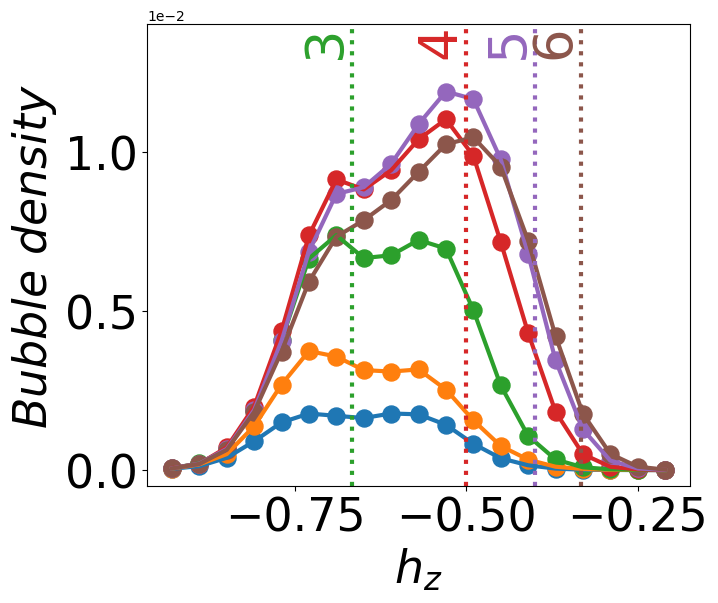

In [7]:
"""
FALSE VACUUM DECAY PARAMETERS
"""

# Specify the number of spins
number_of_spins = [5564]
# Specify the value of J in the transverse field Ising model
J_value = [-1.0]
# Specify the value of hx in the transverse field Ising model
hx_value = np.array([.05])

"""
QUANTUM ANNEALING PARAMETERS
"""

# Specify the D-Wave Leap user profile to use when submitting jobs
profil = 'jvodebjuelich'
sampler = DWaveSampler(profile=profil)
print("Connected to sampler", sampler.solver.name)
# Specify the maximum slope in annealing schedule
max_slope = 1./sampler.properties["annealing_time_range"][0]
print("Maximum slope allowed on this solver is {:.2f}.".format(max_slope))
# Specify the maximum slope in hz schedule
h_max_slope = 360.
print(f"*WARNING* PLEASE CHECK! h gain schedule max slope: ", h_max_slope)
# Specify the number of reads from the annealer
number_of_reads = [1000]
# Specify dir for storing results
results_dir = 'C:\\Users\\jakav\\Desktop\\False vacuum decay temporary\\Rezultati-18th-sweep\\'
# Specify the mode of output from the D-Wave machine, either time - 'raw' or energy - 'histogram' ordered
answer_mode = 'raw'
# Specify whether to use D-Wave's auto scaling for the couplings and external fields or not
auto_scale = False
# Specify the value for the weight of physical qubits chains comprising logical qubits
chain_strength = 1.
# Specify how to obtain the embedding, either calculate a new one (embedding_string='new') or use an existing one from file (embedding_string='existing')
embedding_string = 'ring-embedding-5.4-'
# Specify how to obtain the embedding, either calculate a new one (embedding_string='new') or use an existing one from file (embedding_string='existing')
embedding_string_short = 're54'
# Specify the dir of the embeddings to be used
embedding_dir = 'C:\\Users\\jakav\\Desktop\\False vacuum decay temporary\\Embeddings\\'
# Specify for embeddings made apriori the number of physical qubits NP required for NL logical qubits {NL: NP}
embnpqs = {10: 10, 50: 50, 100: 100, 500: 500, 1000: 1001, 2000: 2000, 3000: 3004, 4000: 4001, 5000: 5000, 5447: 5447, 5564: 5564, 5565: 5565}
# Specify how long to wait in us in between individual runs in the same submission
readout_thermalization = 0.
# Specify what values A(sr) and B(sr) are to be reached in the pause section of the annealing schedule
#s_value = [hx_to_s(hxv, abs(J)) for hxv in hx_value]
# Specify the type of annealing schedule, either 'pause_anneal' or 'reverse_anneal'
anneal_schedule_string = 'ra'

"""PAUSE ANNEALING PARAMETERS"""

# Specify when in us the second rampup ends and therefore the whole pause anneal schedule
anneal_time = ['NOT USED HERE']
# Specify when in us to end the first rampup, starting the pause
begin_pause = ['NOT USED HERE']
# Specify when in us to begin the second rampup, ending the pause
end_pause = ['NOT USED HERE']

"""REVERSE ANNEALING PARAMETERS"""

# Specify the duration in us of the duration of the first linear ramp down from s=1 to s=s_value
initial_ramp_time = [10.]
# Specify the duration in us of the pause duration at s=s_value
t1 = np.linspace(0.,1.,num=101).round(3)
#pause_time = np.concatenate((t1, t2, t3, t4))
pause_time = t1
# Specify the duration in us of the measurement linear ramp from s=s_value back to s=1
measurement_time = [0.]
# Specify the description of the classical initial state of the system, e.g. [0, 1, 1, 0, 0, ...]
init_state = 'all_1'
# Specify wheter to reinitialize always back to init_state before performing another reverse anneal
reinitialize_state = True

"""hz SCHEDULE QUENCH PARAMETERS"""

# Specify the type of h schedule
h_schedule_string = 'q'
# Specify the magnitude of the hz field
hz_value = -np.linspace(.01,1.,num=100).round(3)
#Specify the time of the quench
quench_time = [0.]
#offset_time = [round(t, 2) for t in np.arange(-0.3, 0., 0.01)]

analysis_results_dir = 'Data/'

with gzip.open(analysis_results_dir + 'fvd_mags_18th_sweep_LZ_check.txt.gz', "r") as f:
    fvd_mags = eval(f.read())

x_axis = np.array(hz_value[20:93:4])

for jv in J_value:
    for irt in initial_ramp_time:
        for mt in measurement_time:
            for qt in quench_time:
                for nr in number_of_reads:
                    
                    for nos in number_of_spins:
                        for hxv in hx_value:
                            
                            dta = (1.-hx_to_s(hxv))/max_slope
                            if mt == 0.:
                                mt = round(dta,6)
                            
                            pt = pause_time[-1]
                            
                            third_axis = ['l1','l2','l3','l4','l5','l6']
                            third_axis_name = '$Bubble$ $size$'
                            
                            colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
                            fig, axs = plt.subplots(figsize=(7, 6))
                            plt.ticklabel_format(axis='y', style='sci', scilimits=(0,4))
                            plt.xlabel('$h_z$', fontsize = 33)
                            plt.ylabel('$Bubble$ $density$', fontsize = 33)
                            markers = [str(i) for i in range(1,7)]
                            axs.tick_params(axis='both', labelsize=33)
                            
                            cnt = 0
                            
                            for ta in third_axis:
                                    
                                x = []
                                y = []
                                
                                for xa in x_axis:

                                    try:
                                        y.append(fvd_mags[(nos,jv,hxv,xa,irt,pt,mt,qt,nr,ta)])
                                        x.append(xa)
                                    except:
                                        continue
                                    
                                axs.plot(x, y, ls='solid', lw=3, color=colors[cnt])
                                axs.scatter(x, y, s=150, color=colors[cnt])
                                #for xi,yi in zip([x[15]],[y[15]]):
                                #    axs.text(xi, yi, markers[cnt], color=colors[cnt])
                                    
                                axs.set_ylim(-.0005,.014)
                                
                                cnt += 1
                                
                            for res in [3,4,5,6]:
                                axs.axvline(-2/res, color=colors[res-1], ls=':', lw=3.)
                                axs.text(-2/res, 1., str(res), fontsize=38, color=colors[res-1], ha='right', va='top', rotation=90,
                                         transform=axs.get_xaxis_transform())
plt.savefig('Images/Fig2c.pdf', bbox_inches='tight')
plt.savefig('Images/Fig2c.svg', bbox_inches='tight')
plt.savefig('Images/Fig2c.png', bbox_inches='tight')

Connected to sampler Advantage_system5.4
Maximum slope allowed on this solver is 2.00.
*WARNING* PLEASE CHECK! h gain schedule max slope:  360.0


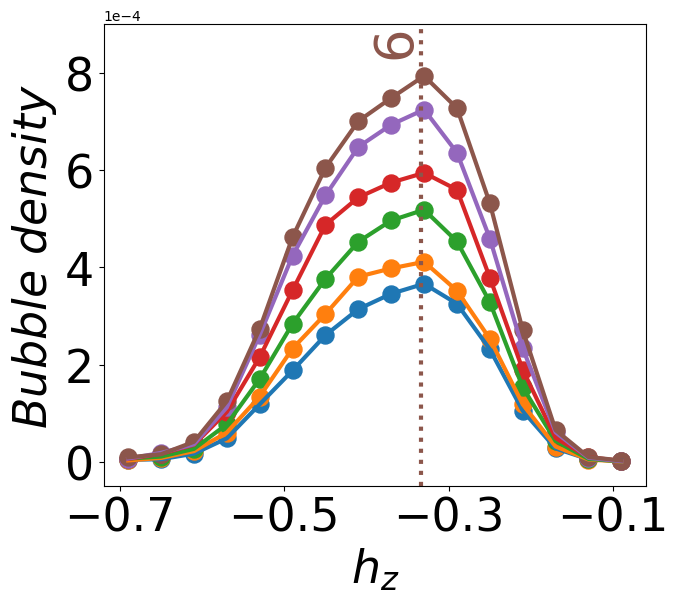

In [8]:
"""
FALSE VACUUM DECAY PARAMETERS
"""

# Specify the number of spins
number_of_spins = [5564]
# Specify the value of J in the transverse field Ising model
J_value = [-1.0]
# Specify the value of hx in the transverse field Ising model
hx_value = np.array([.1])

"""
QUANTUM ANNEALING PARAMETERS
"""

# Specify the D-Wave Leap user profile to use when submitting jobs
profil = 'jvodebjuelich'
sampler = DWaveSampler(profile=profil)
print("Connected to sampler", sampler.solver.name)
# Specify the maximum slope in annealing schedule
max_slope = 1./sampler.properties["annealing_time_range"][0]
print("Maximum slope allowed on this solver is {:.2f}.".format(max_slope))
# Specify the maximum slope in hz schedule
h_max_slope = 360.
print(f"*WARNING* PLEASE CHECK! h gain schedule max slope: ", h_max_slope)
# Specify the number of reads from the annealer
number_of_reads = [1000]
# Specify dir for storing results
results_dir = 'C:\\Users\\jakav\\Desktop\\False vacuum decay temporary\\Rezultati-20th-sweep\\'
# Specify the mode of output from the D-Wave machine, either time - 'raw' or energy - 'histogram' ordered
answer_mode = 'raw'
# Specify whether to use D-Wave's auto scaling for the couplings and external fields or not
auto_scale = False
# Specify the value for the weight of physical qubits chains comprising logical qubits
chain_strength = 1.
# Specify how to obtain the embedding, either calculate a new one (embedding_string='new') or use an existing one from file (embedding_string='existing')
embedding_string = 'ring-embedding-5.4-'
# Specify how to obtain the embedding, either calculate a new one (embedding_string='new') or use an existing one from file (embedding_string='existing')
embedding_string_short = 're54'
# Specify the dir of the embeddings to be used
embedding_dir = 'C:\\Users\\jakav\\Desktop\\False vacuum decay temporary\\Embeddings\\'
# Specify for embeddings made apriori the number of physical qubits NP required for NL logical qubits {NL: NP}
embnpqs = {10: 10, 50: 50, 100: 100, 500: 500, 1000: 1001, 2000: 2000, 3000: 3004, 4000: 4001, 5000: 5000, 5447: 5447, 5564: 5564, 5565: 5565}
# Specify how long to wait in us in between individual runs in the same submission
readout_thermalization = 0.
# Specify what values A(sr) and B(sr) are to be reached in the pause section of the annealing schedule
#s_value = [hx_to_s(hxv, abs(J)) for hxv in hx_value]
# Specify the type of annealing schedule, either 'pause_anneal' or 'reverse_anneal'
anneal_schedule_string = 'ra'

"""PAUSE ANNEALING PARAMETERS"""

# Specify when in us the second rampup ends and therefore the whole pause anneal schedule
anneal_time = ['NOT USED HERE']
# Specify when in us to end the first rampup, starting the pause
begin_pause = ['NOT USED HERE']
# Specify when in us to begin the second rampup, ending the pause
end_pause = ['NOT USED HERE']

"""REVERSE ANNEALING PARAMETERS"""

# Specify the duration in us of the duration of the first linear ramp down from s=1 to s=s_value
initial_ramp_time = [10.]
# Specify the duration in us of the pause duration at s=s_value
t1 = np.linspace(0.,50.,num=51).round(3)
#pause_time = np.concatenate((t1, t2, t3, t4))
pause_time = t1
# Specify the duration in us of the measurement linear ramp from s=s_value back to s=1
measurement_time = [0.]
# Specify the description of the classical initial state of the system, e.g. [0, 1, 1, 0, 0, ...]
init_state = 'all_1'
# Specify wheter to reinitialize always back to init_state before performing another reverse anneal
reinitialize_state = True

"""hz SCHEDULE QUENCH PARAMETERS"""

# Specify the type of h schedule
h_schedule_string = 'q'
# Specify the magnitude of the hz field
hz_value = -np.linspace(.01,1.,num=100).round(3)
#Specify the time of the quench
quench_time = [0.]
#offset_time = [round(t, 2) for t in np.arange(-0.3, 0., 0.01)]

analysis_results_dir = 'Data/'

with gzip.open(analysis_results_dir + 'fvd_mags_20th_sweep_LZ_check.txt.gz', "r") as f:
    fvd_mags = eval(f.read())

x_axis = np.array(hz_value[8:70:4])

for jv in J_value:
    for irt in initial_ramp_time:
        for mt in measurement_time:
            for qt in quench_time:
                for nr in number_of_reads:
                    
                    for nos in number_of_spins:
                        for hxv in hx_value:
                            
                            dta = (1.-hx_to_s(hxv))/max_slope
                            if mt == 0.:
                                mt = round(dta,6)
                            
                            pt = pause_time[1]
                            
                            third_axis = ['l1','l2','l3','l4','l5','l6']
                            third_axis_name = '$Bubble$ $size$'
                            
                            colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
                            fig, axs = plt.subplots(figsize=(7, 6))
                            plt.ticklabel_format(axis='y', style='sci', scilimits=(0,4))
                            plt.xlabel('$h_z$', fontsize = 33)
                            plt.ylabel('$Bubble$ $density$', fontsize = 33)
                            markers = [str(i) for i in range(1,7)]
                            axs.tick_params(axis='both', labelsize=33)
                            axs.set_xticks([-.1,-.3,-.5,-.7])
                            
                            cnt = 0
                            
                            for ta in third_axis:
                                    
                                x = []
                                y = []
                                
                                for xa in x_axis:

                                    try:
                                        y.append(fvd_mags[(nos,jv,hxv,xa,irt,pt,mt,qt,nr,ta)])
                                        x.append(xa)
                                    except:
                                        continue
                                    
                                axs.plot(x, y, ls='solid', lw=3, color=colors[cnt])
                                axs.scatter(x, y, s=150, color=colors[cnt])
                                #for xi,yi in zip(x,y):
                                #    axs.text(xi, yi, markers[cnt], color=colors[cnt])
                                
                                axs.set_ylim(-.00005,.0009)
                                
                                cnt += 1
                                
                            for res in [6]:
                                axs.axvline(-2/res, color=colors[res-1], ls=':', lw=3.)
                                axs.text(-2/res, 1., str(res), fontsize=38, color=colors[res-1], ha='right', va='top', rotation=90,
                                         transform=axs.get_xaxis_transform())
plt.savefig('Images/Fig2d.pdf', bbox_inches='tight')
plt.savefig('Images/Fig2d.svg', bbox_inches='tight')
plt.savefig('Images/Fig2d.png', bbox_inches='tight')

*WARNING* PLEASE CHECK! h gain schedule max slope:  399.0


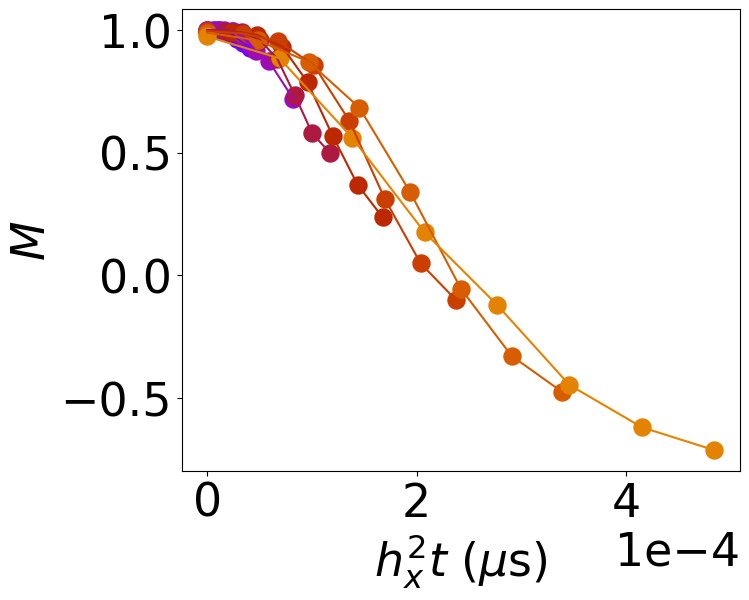

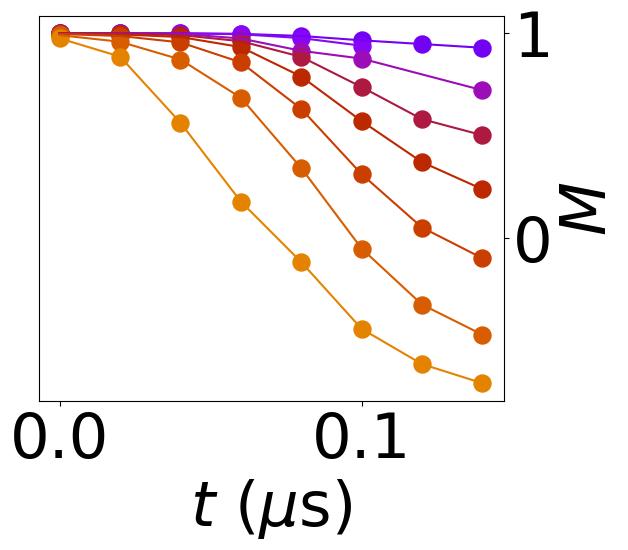

In [9]:
"""
FALSE VACUUM DECAY PARAMETERS
"""

# Specify the number of spins
number_of_spins = [5564]
# Specify the value of J in the transverse field Ising model
J_value = [-1.0]
# Specify the value of hx in the transverse field Ising model
hx_value = np.array([0.001 , 0.0012, 0.0014, 0.0017, 0.002 , 0.0024, 0.0029, 0.0035,
       0.0041, 0.0049, 0.0059, 0.007 , 0.0084, 0.01  , 0.0119, 0.0143,
       0.017 , 0.0203, 0.0242, 0.0289, 0.0346, 0.0412, 0.0492, 0.0588])
boundary_conditions = 'obc'

"""
QUANTUM ANNEALING PARAMETERS
"""

# Specify the D-Wave Leap user profile to use when submitting jobs
#profil = 'jvodebjuelich'
#sampler = DWaveSampler(profile=profil)
#print("Connected to sampler", sampler.solver.name)
# Specify the maximum slope in annealing schedule
max_slope = 2.
#print("Maximum slope allowed on this solver is {:.2f}.".format(max_slope))
# Specify the maximum slope in hz schedule
h_max_slope = 399.
print(f"*WARNING* PLEASE CHECK! h gain schedule max slope: ", h_max_slope)
# Specify the number of reads from the annealer
number_of_reads = [1000]
# Specify dir for storing results
results_dir = 'C:\\Users\\jakav\\Desktop\\False vacuum decay temporary\\Rezultati-13th-sweep\\'
# Specify the mode of output from the D-Wave machine, either time - 'raw' or energy - 'histogram' ordered
answer_mode = 'raw'
# Specify whether to use D-Wave's auto scaling for the couplings and external fields or not
auto_scale = False
# Specify the value for the weight of physical qubits chains comprising logical qubits
chain_strength = 1.
# Specify how to obtain the embedding, either calculate a new one (embedding_string='new') or use an existing one from file (embedding_string='existing')
embedding_string = 'ring-embedding-5.4-'
# Specify how to obtain the embedding, either calculate a new one (embedding_string='new') or use an existing one from file (embedding_string='existing')
embedding_string_short = 're54'
# Specify the dir of the embeddings to be used
embedding_dir = 'C:\\Users\\jakav\\Desktop\\False vacuum decay temporary\\Embeddings\\'
# Specify for embeddings made apriori the number of physical qubits NP required for NL logical qubits {NL: NP}
embnpqs = {10: 10, 50: 50, 100: 100, 500: 500, 1000: 1001, 2000: 2000, 3000: 3004, 4000: 4001, 5000: 5000, 5447: 5447, 5564: 5564, 5565: 5565}
# Specify how long to wait in us in between individual runs in the same submission
readout_thermalization = 0.
# Specify what values A(sr) and B(sr) are to be reached in the pause section of the annealing schedule
#s_value = [hx_to_s(hxv, abs(J)) for hxv in hx_value]
# Specify the type of annealing schedule, either 'pause_anneal' or 'reverse_anneal'
anneal_schedule_string = 'ra'

"""PAUSE ANNEALING PARAMETERS"""

# Specify when in us the second rampup ends and therefore the whole pause anneal schedule
anneal_time = ['NOT USED HERE']
# Specify when in us to end the first rampup, starting the pause
begin_pause = ['NOT USED HERE']
# Specify when in us to begin the second rampup, ending the pause
end_pause = ['NOT USED HERE']

"""REVERSE ANNEALING PARAMETERS"""

# Specify the duration in us of the duration of the first linear ramp down from s=1 to s=s_value
initial_ramp_time = [100.]
# Specify the duration in us of the pause duration at s=s_value
t1 = np.linspace(0.,2.,num=201).round(3)
#pause_time = np.concatenate((t1, t2, t3, t4))
pause_time = t1
# Specify the duration in us of the measurement linear ramp from s=s_value back to s=1
measurement_time = [0.]
# Specify the description of the classical initial state of the system, e.g. [0, 1, 1, 0, 0, ...]
init_state = 'all_1'
# Specify wheter to reinitialize always back to init_state before performing another reverse anneal
reinitialize_state = True

"""hz SCHEDULE QUENCH PARAMETERS"""

# Specify the type of h schedule
h_schedule_string = 'q'
# Specify the magnitude of the hz field
hz_value = -np.array([1.])
#Specify the time of the quench
quench_time = [0.]
#offset_time = [round(t, 2) for t in np.arange(-0.3, 0., 0.01)]

analysis_results_dir = 'Data/'

with gzip.open(analysis_results_dir + 'fvd_mags_13th_sweep.txt.gz', "r") as f:
    fvd_mags = eval(f.read())

x_axis = pause_time[15:30:2]

for jv in J_value:
    for irt in initial_ramp_time:
        for mt in measurement_time:
            for qt in quench_time:
                for nr in number_of_reads:
                    
                    for nos in number_of_spins:
                        for hzv in hz_value:
                            
                            third_axis = hx_value[16:]
                            third_axis_name = '$h_x$'
                            
                            cmap = plt.get_cmap('gnuplot')
                            colors = [cmap(i) for i in np.linspace(.2, .8, len(third_axis))]
                            fig, axs = plt.subplots(figsize=(7.2, 6))
                            #plt.title('L = '+str(nos)+', hz = '+str(hzv)+', irt = '+str(irt)+', mt = '+str(mt), fontsize = 28)
                            normalize = mcolors.Normalize(vmin=min(third_axis), vmax=max(third_axis))
                            colormap = plt.get_cmap('gnuplot')
                            scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
                            scalarmappaple.set_array(third_axis)
                            plt.xlabel('$h_x^2 t$ ($\mu$s)', fontsize = 33)
                            plt.ylabel('$M$', fontsize = 33)
                            axs.tick_params(axis='both', labelsize=33)
                            axs.ticklabel_format(axis='x', style='sci', scilimits=(0,4))
                            axs.xaxis.offsetText.set_fontsize(33)
                            
                            cnt = 0
                            
                            for ta in third_axis:
                                
                                dta = (1.-hx_to_s(ta))/max_slope
                                if mt == 0.:
                                    mt1 = round(dta,6)
                                    
                                x = []
                                y = []
                                
                                for xa in x_axis:
                                    
                                    try:
                                        y.append(fvd_mags[(nos,jv,ta,hzv,irt,xa,mt1,qt,nr,'mean')])
                                        x.append(xa)
                                    except:
                                        continue
                                    
                                #axs.hlines(0., min(x_axis), max(x_axis), linestyles='dashed', colors='black', alpha=0.6)
                                    
                                axs.plot(ta**2 * (np.array(x) - np.array(x[0])), y, '-', color=colors[cnt], label=f'hzv={third_axis[cnt]}')
                                axs.scatter(ta**2 * (np.array(x) - np.array(x[0])), y, s=150, color=colors[cnt], label=f'hzv={third_axis[cnt]}')
                                
                                cnt += 1
plt.savefig('Images/Fig3b.pdf', bbox_inches='tight')
plt.savefig('Images/Fig3b.svg', bbox_inches='tight')
plt.savefig('Images/Fig3b.png', bbox_inches='tight')

x_axis = pause_time[15:30:2]

for jv in J_value:
    for irt in initial_ramp_time:
        for mt in measurement_time:
            for qt in quench_time:
                for nr in number_of_reads:
                    
                    for nos in number_of_spins:
                        for hzv in hz_value:
                            
                            third_axis = hx_value[16:]
                            third_axis_name = '$h_x$'
                            
                            cmap = plt.get_cmap('gnuplot')
                            colors = [cmap(i) for i in np.linspace(.2, .8, len(third_axis))]
                            fig, axs = plt.subplots(figsize=(6, 5))
                            #plt.title('L = '+str(nos)+', hz = '+str(hzv)+', irt = '+str(irt)+', mt = '+str(mt), fontsize = 28)
                            normalize = mcolors.Normalize(vmin=min(third_axis), vmax=max(third_axis))
                            colormap = plt.get_cmap('gnuplot')
                            scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
                            scalarmappaple.set_array(third_axis)
                            plt.xlabel('$t$ ($\mu$s)', fontsize = 45)
                            plt.ylabel('$M$', fontsize = 45)
                            axs.tick_params(axis='both', labelsize=45)
                            
                            cnt = 0
                            
                            for ta in third_axis:
                                
                                dta = (1.-hx_to_s(ta))/max_slope
                                if mt == 0.:
                                    mt1 = round(dta,6)
                                    
                                x = []
                                y = []
                                
                                for xa in x_axis:
                                    
                                    try:
                                        y.append(fvd_mags[(nos,jv,ta,hzv,irt,xa,mt1,qt,nr,'mean')])
                                        x.append(xa)
                                    except:
                                        continue
                                    
                                #axs.hlines(0., min(x_axis), max(x_axis), linestyles='dashed', colors='black', alpha=0.6)
                                
                                axs.plot((np.array(x) - np.array(x[0])), y, '-', color=colors[cnt], label=f'hzv={third_axis[cnt]}')
                                axs.scatter((np.array(x) - np.array(x[0])), y, s=150, color=colors[cnt], label=f'hzv={third_axis[cnt]}')
                                axs.yaxis.set_label_position("right")
                                axs.yaxis.tick_right()
                                
                                cnt += 1
plt.savefig('Images/Fig3bInset.pdf', bbox_inches='tight')
plt.savefig('Images/Fig3bInset.svg', bbox_inches='tight')
plt.savefig('Images/Fig3bInset.png', bbox_inches='tight')

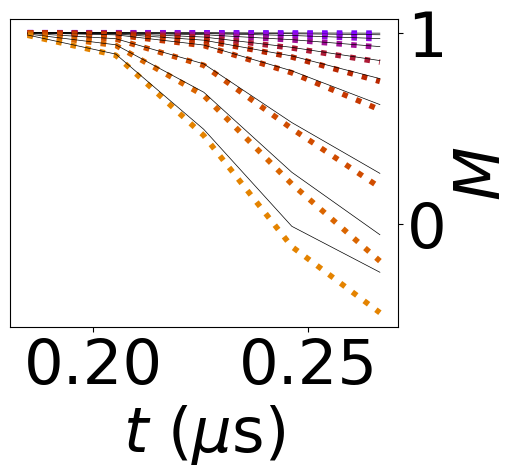

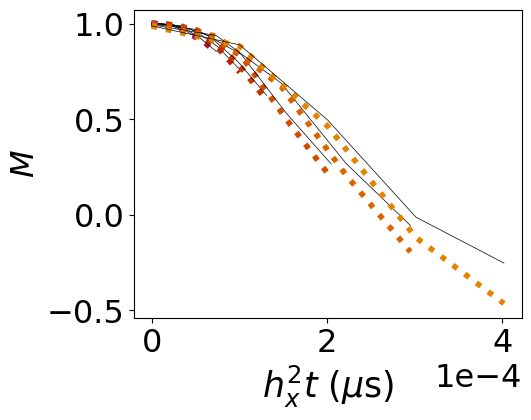

In [10]:
L = 3
J = -1.
es = fB(1.)*1.
t0 = hbar/es*2.*10**6 # energy timescale of H(t) in \mu s
pts = np.linspace(.0001,.8,40) # pause time in \mu s
#pts = np.array([.1,.15]) # pause time in \mu s
irts = [.272] # initial ramp time in \mu s
mts = [.272] # measurement time in \mu s
tauzs = [.1]
hxrange = -np.array([.01,.015,.02,.025,.03,.035,.04,.05,.06,.07])
hz_value = np.array([1.])

etas = [.2]

hzstr = 'exphz1'

tag = 'reproducing_DWave_3'
dir = 'Data/'
df = pd.read_csv(dir+'BlochRefield_L_'+str(L)+'_J_'+str(J).replace('.','_')+'_irt_'+str(irts[0]).replace('.','_')+'_mt_'+str(mts[0]).replace('.','_')+\
             '_eta_'+str(etas[0]).replace('.','_')+'_hz_'+hzstr+'_tag_'+tag+'.csv')


turning_point1 = 9
turning_point2 = 14

hxrange = np.flip(np.unique(df['hx'].to_numpy()))
hz_value = np.unique(df['hz'].to_numpy())
pts = np.unique(df['pt'].to_numpy())
fvd_mag = np.full((len(hxrange),len(hz_value),len(pts)),-2.)
for ihz, hz in enumerate(hz_value):
    for ihx, hx in enumerate(hxrange):
        for ip, pt in enumerate(pts):
            fvd_mag[ihx,ihz,ip] = df['M'].loc[(df['hx'] == hx) & (df['hz'] == hz) & (df['pt'] == pt)].to_numpy()[0]

tag = 'reproducing_DWave_3_eff'
dir = 'Data/'
df = pd.read_csv(dir+'BlochRefield_L_'+str(L)+'_J_'+str(J).replace('.','_')+'_irt_'+str(irts[0]).replace('.','_')+'_mt_'+str(mts[0]).replace('.','_')+\
             '_eta_'+str(etas[0]).replace('.','_')+'_hz_'+hzstr+'_tag_'+tag+'.csv')

hxrange = np.flip(np.unique(df['hx'].to_numpy()))
hz_value = np.unique(df['hz'].to_numpy())
pts = np.unique(df['pt'].to_numpy())
fvd_mag_eff = np.full((len(hxrange),len(hz_value),len(pts)),-2.)
for ihz, hz in enumerate(hz_value):
    for ihx, hx in enumerate(hxrange):
        for ip, pt in enumerate(pts):
            fvd_mag_eff[ihx,ihz,ip] = df['M'].loc[(df['hx'] == hx) & (df['hz'] == hz) & (df['pt'] == pt)].to_numpy()[0]

third_axis = hxrange
third_axis_name = '$h_x$'
cmap = plt.get_cmap('gnuplot')
colors = [cmap(i) for i in np.linspace(.2, .8, len(third_axis))]
for ihz, hz in enumerate(hz_value):
    fig, ax = plt.subplots(figsize=(5,4))
    plt.xlabel('$t$ ($\mu$s)', fontsize = 45)
    plt.ylabel('$M$', fontsize = 45)
    ax.tick_params(axis='x',labelsize=45)
    ax.tick_params(axis='y',labelsize=45)
    cmap = plt.get_cmap('gnuplot')
    colors = [cmap(i) for i in np.linspace(.2, .8, len(third_axis))]
    #ax.set_xticks([0.,.2,.4,.6,.8])
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    for sind in range(len(hxrange)):
        ax.plot(pts[turning_point1:turning_point2], fvd_mag[sind,ihz][turning_point1:turning_point2], color=colors[sind], ls=':', lw=4)
        ax.plot(pts[turning_point1:turning_point2], fvd_mag_eff[sind,ihz][turning_point1:turning_point2], color='black', lw=.5)
plt.savefig('Images/Fig3cInset.pdf', bbox_inches='tight')
plt.savefig('Images/Fig3cInset.svg', bbox_inches='tight')
plt.savefig('Images/Fig3cInset.png', bbox_inches='tight')

third_axis = hxrange
third_axis_name = '$h_x$'
cmap = plt.get_cmap('gnuplot')
colors = [cmap(i) for i in np.linspace(.2, .8, len(third_axis))]
for ihz, hz in enumerate(hz_value):
    fig, ax = plt.subplots(figsize=(5,4))
    plt.xlabel('$h_x^2 t$ ($\mu$s)', fontsize = 25)
    plt.ylabel('$M$', fontsize = 23)
    ax.tick_params(axis='x',labelsize=23)
    ax.tick_params(axis='y',labelsize=23)
    ax.ticklabel_format(axis='x', style='sci', scilimits=(0,4))
    ax.xaxis.offsetText.set_fontsize(23)
    #ax.set_xticks([.0,.0005,.001])
    cmap = plt.get_cmap('gnuplot')
    colors = [cmap(i) for i in np.linspace(.2, .8, len(third_axis))]
    for sind in range(len(hxrange)):
        ax.plot(abs(hxrange[sind])**2 * (pts[turning_point1:turning_point2]-pts[turning_point1]), fvd_mag[sind,ihz][turning_point1:turning_point2], color=colors[sind], ls=':', lw=4)
        ax.plot(abs(hxrange[sind])**2 * (pts[turning_point1:turning_point2]-pts[turning_point1]), fvd_mag_eff[sind,ihz][turning_point1:turning_point2], color='black', lw=.5)
plt.savefig('Images/Fig3c.pdf', bbox_inches='tight')
plt.savefig('Images/Fig3c.svg', bbox_inches='tight')
plt.savefig('Images/Fig3c.png', bbox_inches='tight')

Connected to sampler Advantage_system5.4
Maximum slope allowed on this solver is 2.00.
*WARNING* PLEASE CHECK! h gain schedule max slope:  399.0


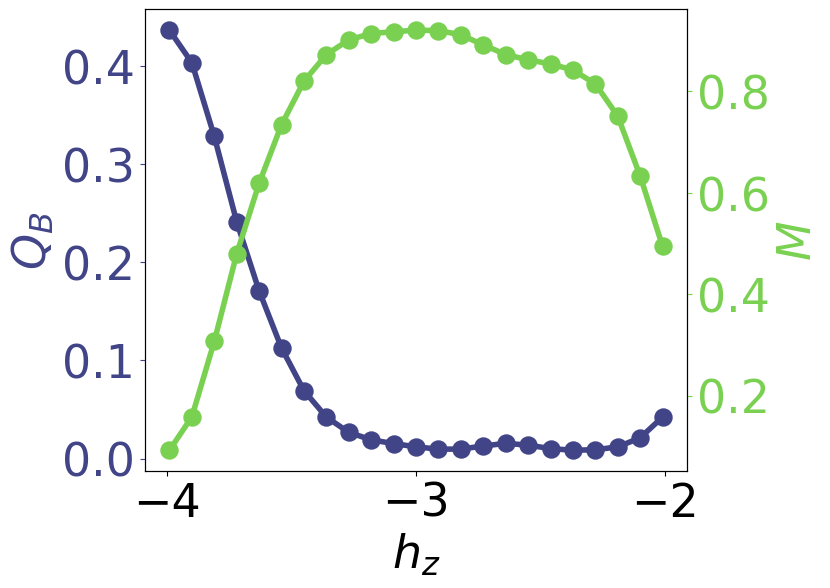

In [11]:
"""
FALSE VACUUM DECAY PARAMETERS
"""

# Specify the number of spins
number_of_spins = [5564]
# Specify the value of J in the transverse field Ising model
J_value = [-1.0]
# Specify the value of hx in the transverse field Ising model
hx_value = np.array([.002])

"""
QUANTUM ANNEALING PARAMETERS
"""

# Specify the D-Wave Leap user profile to use when submitting jobs
profil = 'jvodebjuelich'
sampler = DWaveSampler(profile=profil)
print("Connected to sampler", sampler.solver.name)
# Specify the maximum slope in annealing schedule
max_slope = 1./sampler.properties["annealing_time_range"][0]
print("Maximum slope allowed on this solver is {:.2f}.".format(max_slope))
# Specify the maximum slope in hz schedule
h_max_slope = 399.
print(f"*WARNING* PLEASE CHECK! h gain schedule max slope: ", h_max_slope)
# Specify the number of reads from the annealer
number_of_reads = [1000]
# Specify dir for storing results
results_dir = 'C:\\Users\\jakav\\Desktop\\False vacuum decay temporary\\Rezultati\\'
# Specify the mode of output from the D-Wave machine, either time - 'raw' or energy - 'histogram' ordered
answer_mode = 'raw'
# Specify whether to use D-Wave's auto scaling for the couplings and external fields or not
auto_scale = False
# Specify the value for the weight of physical qubits chains comprising logical qubits
chain_strength = 1.
# Specify how to obtain the embedding, either calculate a new one (embedding_string='new') or use an existing one from file (embedding_string='existing')
embedding_string = 'ring-embedding-5.4-'
# Specify how to obtain the embedding, either calculate a new one (embedding_string='new') or use an existing one from file (embedding_string='existing')
embedding_string_short = 're54'
# Specify the dir of the embeddings to be used
embedding_dir = 'C:\\Users\\jakav\\Desktop\\False vacuum decay temporary\\Embeddings\\'
# Specify for embeddings made apriori the number of physical qubits NP required for NL logical qubits {NL: NP}
embnpqs = {10: 10, 50: 50, 100: 100, 500: 500, 1000: 1001, 2000: 2000, 3000: 3004, 4000: 4001, 5000: 5000, 5447: 5447, 5564: 5564, 5565: 5565}
# Specify how long to wait in us in between individual runs in the same submission
readout_thermalization = 0.
# Specify what values A(sr) and B(sr) are to be reached in the pause section of the annealing schedule
#s_value = [hx_to_s(hxv, abs(J)) for hxv in hx_value]
# Specify the type of annealing schedule, either 'pause_anneal' or 'reverse_anneal'
anneal_schedule_string = 'ra'

"""PAUSE ANNEALING PARAMETERS"""

# Specify when in us the second rampup ends and therefore the whole pause anneal schedule
anneal_time = ['NOT USED HERE']
# Specify when in us to end the first rampup, starting the pause
begin_pause = ['NOT USED HERE']
# Specify when in us to begin the second rampup, ending the pause
end_pause = ['NOT USED HERE']

"""REVERSE ANNEALING PARAMETERS"""

# Specify the duration in us of the duration of the first linear ramp down from s=1 to s=s_value
initial_ramp_time = [100.]
# Specify the duration in us of the pause duration at s=s_value
t1 = np.linspace(0.,2.,num=101).round(3)
#pause_time = np.concatenate((t1, t2, t3, t4))
pause_time = t1
# Specify the duration in us of the measurement linear ramp from s=s_value back to s=1
measurement_time = [0.]
# Specify the description of the classical initial state of the system, e.g. [0, 1, 1, 0, 0, ...]
init_state = 'all_1'
# Specify wheter to reinitialize always back to init_state before performing another reverse anneal
reinitialize_state = True

"""hz SCHEDULE QUENCH PARAMETERS"""

# Specify the type of h schedule
h_schedule_string = 'q'
# Specify the magnitude of the hz field
hz_value = -np.linspace(0.01,4.,num=400).round(3)
#Specify the time of the quench
quench_time = [0.]
#offset_time = [round(t, 2) for t in np.arange(-0.3, 0., 0.01)]

analysis_results_dir = 'Data/'

with gzip.open(analysis_results_dir + 'fvd_mags_11th_sweep_PXP_check.txt.gz', "r") as f:
    fvd_mags = eval(f.read())

x_axis = hz_value[200::9]

for jv in J_value:
    for irt in initial_ramp_time:
        for mt in measurement_time:
            for qt in quench_time:
                for nr in number_of_reads:
                    
                    for nos in number_of_spins:
                        for hxv in hx_value:
                            
                            third_axis = np.array(pause_time[19:20:2])
                            third_axis_name = '$t$ $(\mu s)$'
                            
                            cmap = plt.get_cmap('viridis')
                            colors = [cmap(i) for i in np.linspace(.2, .8, 2)]
                            fig, axs = plt.subplots(figsize=(7, 6))
                            axs.set_xlabel('$h_z$', fontsize = 33)
                            axs.set_ylabel('$Q_{B}$', fontsize = 33, color=colors[0])
                            axs.tick_params(axis='x', labelsize=33)
                            axs.tick_params(axis='y', labelsize=33, colors=colors[0])
                            axs2=axs.twinx()
                            axs2.tick_params(axis='y', labelsize=33, colors=colors[-1])
                            
                            cnt = 0
                            
                            for ta in third_axis:
                                
                                dta = (1.-hx_to_s(hxv))/max_slope
                                if mt == 0.:
                                    mt1 = round(dta,6)
                                    
                                x1 = []
                                y1 = []
                                x2 = []
                                y2 = []
                                
                                for xa in x_axis:
                                    #y1.append(fvd_mags[(nos,jv,hxv,xa,irt,ta,mt1,qt,nr,'Qnn')]/nos)
                                    try:
                                        y1.append(fvd_mags[(nos,jv,hxv,xa,irt,ta,mt1,qt,nr,'Qnn')]/nos)
                                        x1.append(xa)
                                        y2.append(fvd_mags[(nos,jv,hxv,xa,irt,ta,mt1,qt,nr,'mean')]/nos)
                                        x2.append(xa)
                                    except:
                                        continue
                                    
                                #axs.hlines(0., min(x_axis), max(x_axis), linestyles='dashed', colors='black', alpha=0.6)
                                    
                                    cnt += 1
                                    
                                axs.plot(x1, y1, '-', color=colors[0], lw=4)
                                axs.scatter(x1, y1, s=150, color=colors[0])
                                axs2.plot(x2, y2, '-', color=colors[-1], lw=4)
                                axs2.scatter(x2, y2, s=150, color=colors[-1])
                                axs2.tick_params(axis='both', labelsize=33)
                                axs2.set_ylabel('$M$', fontsize = 33, rotation=90, color=colors[-1])
plt.savefig('Images/Fig4b.pdf', bbox_inches='tight')
plt.savefig('Images/Fig4b.svg', bbox_inches='tight')
plt.savefig('Images/Fig4b.png', bbox_inches='tight')

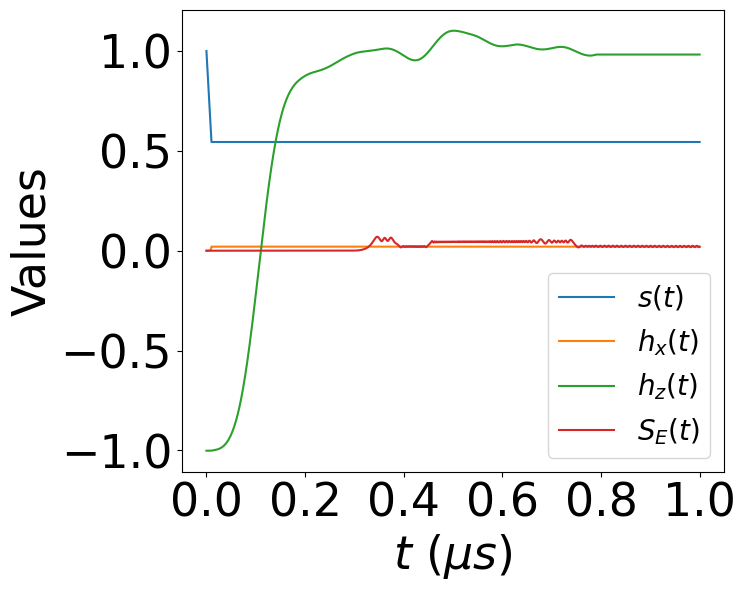

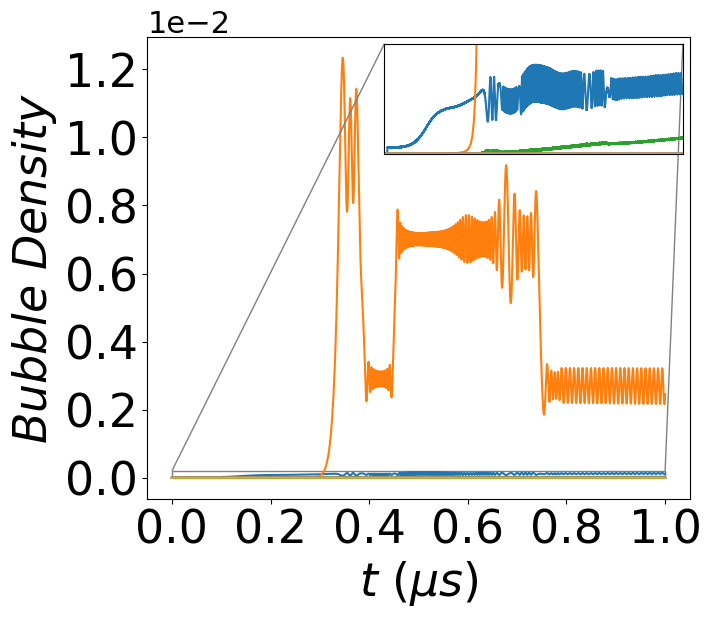

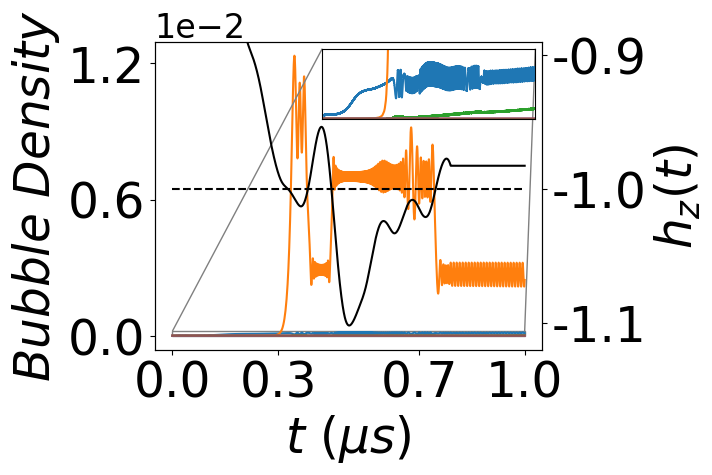

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

# File path
file_path = "Data/Ising_bubble_nb_data_N100_hx00203_dt001_chi128.txt"

# Read data from file
data = np.loadtxt(file_path, delimiter=',')

# Convert time from ns to microseconds
time = data[:, 0] / 1000  # Convert ns to microseconds
s = data[:, 1]
h_x = data[:, 2]
h_z = data[:, 3]
S_E = data[:, 4]
bubble_densities = data[:, 5:]

# Plot s(t), h_x(t), h_z(t), and S_E(t)
plt.figure(figsize=(7, 6))
plt.plot(time, s, label='$s(t)$')
plt.plot(time, h_x, label='$h_x(t)$')
plt.plot(time, h_z, label='$h_z(t)$')
plt.plot(time, S_E, label='$S_E(t)$')
plt.xlabel('$t$ $(\mu s)$', fontsize=33)
plt.xticks(fontsize=33)
plt.yticks(fontsize=33)
plt.ylabel('Values', fontsize=33)
plt.legend(fontsize=20)
plt.show()

# Plot all bubble densities versus time
plt.figure(figsize=(7, 6))
for i in range(bubble_densities.shape[1]):
    plt.plot(time, bubble_densities[:, i], label=f'{i+1}-bubble density')
plt.xlabel('$t$ $(\mu s)$', fontsize=33)
plt.ylabel('$Bubble$ $Density$', fontsize=33)
plt.xticks(fontsize=33)
plt.yticks(fontsize=33)
plt.ticklabel_format(axis='both', style='sci', scilimits=(0,4))

# Create inset of the zoomed region
ax = plt.gca()
ax.yaxis.get_offset_text().set_fontsize(22)
axins = inset_axes(ax,
                    width="55%", # width = 30% of parent_bbox
                    height=1.1, # height : 1 inch
                    loc=1)
for i in range(9):
    axins.plot(time, bubble_densities[:, i], label=f'{i+1}-bubble density')

# Specify the limits of the zoomed region
axins.set_xlim(0, 1)  # Adjust according to your data
axins.set_ylim(0, 0.0002)  # Adjust according to your data
axins.set_xticks([])
axins.set_yticks([])

# Mark the location of the zoomed region in the original plot
mark_inset(ax, axins, loc1=1, loc2=2, fc="none", ec="0.5")

plt.show()

# Plot 1 to 6 bubble densities with inset
plt.figure(figsize=(5, 4))
for i in range(6):
    plt.plot(time, bubble_densities[:, i], label=f'{i+1}-bubble density')
plt.xlabel('$t$ $(\mu s)$', fontsize=35)
plt.ylabel('$Bubble$ $Density$', fontsize=35)
plt.xticks([.0,.3,.7,1.],fontsize=35)
plt.yticks([0.,.006,.012],fontsize=35)
plt.ticklabel_format(axis='both', style='sci', scilimits=(0,4))

# Create inset of the zoomed region
ax = plt.gca()
ax.yaxis.get_offset_text().set_fontsize(24)
axins = inset_axes(ax,
                    width="55%", # width = 30% of parent_bbox
                    height=.7, # height : 1 inch
                    loc=1)
for i in range(6):
    axins.plot(time, bubble_densities[:, i], label=f'{i+1}-bubble density')

# Specify the limits of the zoomed region
axins.set_xlim(0, 1)  # Adjust according to your data
axins.set_ylim(0, 0.0002)  # Adjust according to your data
axins.set_xticks([])
axins.set_yticks([])

# Mark the location of the zoomed region in the original plot
mark_inset(ax, axins, loc1=1, loc2=2, fc="none", ec="0.5")

ax2=ax.twinx()
ax2.plot(time, -h_z, label='$h_z(t)$', color='black')
ax2.set_ylim([-1.12,-.89])
ax2.hlines(-1.,time[0],time[-1],ls='--',color='black')
ax2.set_yticks([-1.1,-1.,-.9],[-1.1,-1.,-.9],fontsize=35)
ax2.set_ylabel('$h_z(t)$', fontsize=35)

plt.savefig('Images/Fig4c.pdf', bbox_inches='tight')
plt.savefig('Images/Fig4c.svg', bbox_inches='tight')
plt.savefig('Images/Fig4c.png', bbox_inches='tight')